## Zooniverse Analysis

In [2]:
import shutil
import json
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
import seaborn as sns
from IPython.display import Image, display, HTML


In [3]:
sns.set_context('poster')

In [4]:
dfzoo = pd.read_csv('/epyc/users/ecbellm/ZTF_Boyajian/ztf-dippers-classifications.csv')

In [5]:
len(dfzoo)

3686

In [6]:
dfzoo.head()

classification_id user_name  user_id               user_ip  workflow_id  \
0          266617263    ebellm  1649740  dc1971a3da808410cc1f        15938   
1          266617278    ebellm  1649740  dc1971a3da808410cc1f        15938   
2          266617290    ebellm  1649740  dc1971a3da808410cc1f        15938   
3          266619181    ebellm  1649740  dc1971a3da808410cc1f        15938   
4          266619215    ebellm  1649740  dc1971a3da808410cc1f        15938   

  workflow_name  workflow_version               created_at  gold_standard  \
0  Scan Dippers               5.7  2020-08-06 21:21:21 UTC            NaN   
1  Scan Dippers               5.7  2020-08-06 21:21:26 UTC            NaN   
2  Scan Dippers               5.7  2020-08-06 21:21:30 UTC            NaN   
3  Scan Dippers               5.7  2020-08-06 21:28:55 UTC            NaN   
4  Scan Dippers               5.7  2020-08-06 21:29:02 UTC            NaN   

   expert                                           metadata  \
0     NaN  {"source":"api","session":"f19869eadb36ed18f90...   
1     NaN  {"source":"api","session":"f19869eadb36ed18f90...   
2     NaN  {"source":"api","session":"f19869eadb36ed18f90...   
3     NaN  {"source":"api","session":"2c287e1b6ae12709ea2...   
4     NaN  {"source":"api","session":"2c287e1b6ae12709ea2...   

                                         annotations  \
0  [{"task":"T0","task_label":"Does this look lik...   
1  [{"task":"T0","task_label":"Does this look lik...   
2  [{"task":"T0","task_label":"Does this look lik...   
3  [{"task":"T0","task_label":"Does this look lik...   
4  [{"task":"T0","task_label":"Does this look lik...   

                                        subject_data  subject_ids  
0  {"48808208":{"retired":null,"ps1_id":901229514...     48808208  
1  {"48808652":{"retired":null,"ps1_id":140201567...     48808652  
2  {"48808343":{"retired":null,"ps1_id":163140505...     48808343  
3  {"48808057":{"retired":null,"ps1_id":161180493...     48808057  
4  {"48807638":{"retired":null,"ps1_id":162381422...     48807638

In [7]:
wnew = dfzoo['created_at'].str.startswith('2021')

In [8]:
np.sum(wnew)

1209

In [9]:
dfzoo = dfzoo[wnew]

this is one classification per row. but includes both v1 and v2 scanning

In [10]:
dfzoo.iloc[0]['annotations']

'[{"task":"T0","task_label":"Is the lightcurve flat outside the dip window?","value":"No"},{"task":"T1","task_label":"Does the lightcurve dip in both bands?","value":"No"},{"task":"T2","task_label":"Is the dip asymmetric?","value":"No"},{"task":"T3","task_label":"Is there one dip or more than one dip in the marked region?","value":"Only one dip"}]'

we only have followup questions for the yes and maybe classificaitons, and some of the early yes/maybe classifications don't have followup at all

In [11]:
dfzoo[['classification_id','user_name']].groupby('user_name').agg(len).sort_values(by='classification_id')

classification_id
user_name                      
ykwang                        1
keatonb                      16
ebellm                       58
kboone                      211
raphillipson                326
jradavenport                597

In [12]:
def get_flat_outside_window(df):
    return dfzoo['annotations'].apply(json.loads).apply(lambda x: x[0]['value'])

def get_dip_both_bands(df):
    return dfzoo['annotations'].apply(json.loads).apply(lambda x: x[1]['value'] if (len(x) > 1) else None)

def get_asymmetric(df):
    return dfzoo['annotations'].apply(json.loads).apply(lambda x: x[2]['value'] if (len(x) > 1) else None)

def get_multiple_dips(df):
    return dfzoo['annotations'].apply(json.loads).apply(lambda x: x[3]['value'] if (len(x) > 1) else None)

def get_ps1_id(df):
    return dfzoo['subject_data'].apply(json.loads).apply(lambda x: list(x.values())[0]['ps1_id'])

In [13]:
dfzoo['flat_outside_window'] = get_flat_outside_window(dfzoo)
dfzoo['dip_both_bands'] = get_dip_both_bands(dfzoo)
dfzoo['asymmetric'] = get_asymmetric(dfzoo)
dfzoo['multiple_dips'] = get_multiple_dips(dfzoo)
dfzoo['ps1_id'] = get_ps1_id(dfzoo)

In [14]:
dfzoo['flat_outside_window'].value_counts()

No, there's other non-dip variability          925
Yes                                            146
No, but the other excursions look like dips    126
No                                              12
Name: flat_outside_window, dtype: int64

In [15]:
dfzoo.groupby(['ps1_id','flat_outside_window']).agg(len)['user_name'].value_counts()

2    415
1    355
3      8
Name: user_name, dtype: int64

In [16]:
dfzoo['dip_both_bands'].value_counts()

Yes                                                   167
Not enough information to tell due to sampling.        77
No, the bands do different things at the same time     35
No                                                      5
Name: dip_both_bands, dtype: int64

In [17]:
dfzoo['asymmetric'].value_counts()

Not enough information to tell due to sampling.    160
Yes                                                 85
No                                                  39
Name: asymmetric, dtype: int64

In [18]:
dfzoo['multiple_dips'].value_counts()

Only one dip                      144
Not enough information to tell     96
More than one dip                  44
Name: multiple_dips, dtype: int64

## Platinum sample: at least one vote w/ flat outside, multiple bands, asymmetric


In [19]:
wplatinum = (dfzoo['flat_outside_window'] == 'Yes') & (dfzoo['dip_both_bands'] == 'Yes') & (dfzoo['asymmetric'] == 'Yes')

In [20]:
np.sum(wplatinum)

32

In [21]:
dfzoo.loc[wplatinum,'ps1_id'].value_counts()

127550814551013958    2
174873213551612939    2
164653156082208171    2
105370976834353455    2
139092829523868897    2
144130880928041281    2
100582959343631974    2
173453595098656338    1
173260619709112041    1
149633039908451296    1
164683281281642831    1
132762755591824101    1
174390256734249897    1
126442877393679193    1
92832901014110779     1
110852855969854057    1
144022996188556147    1
167983111466390337    1
179453445347429323    1
95342700219425059     1
130953164725673763    1
179030313136257708    1
169420489540361407    1
99712689129200776     1
168433257951352509    1
Name: ps1_id, dtype: int64

In [22]:
image_dir = '/astro/users/keatonb/ZTF_Boyajian/Candidate_plots/'

127550814551013958 2


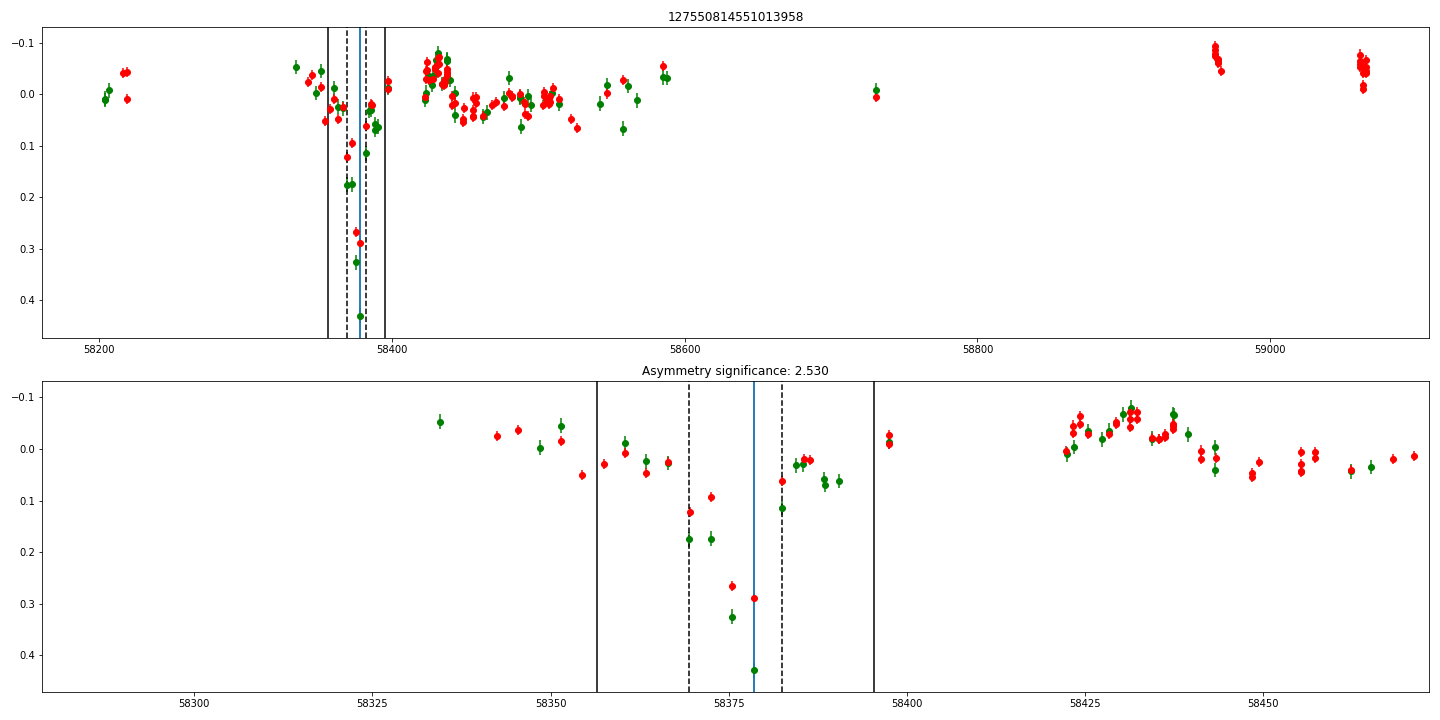

174873213551612939 2


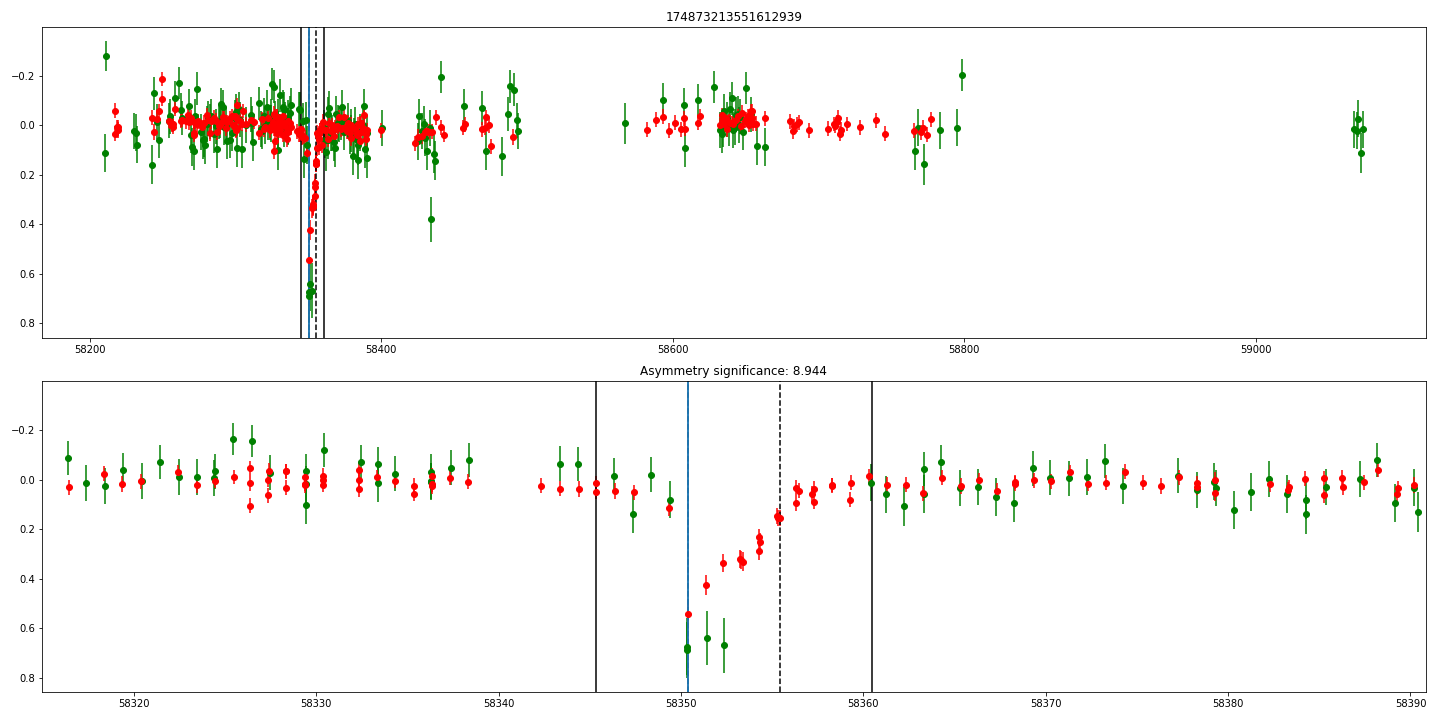

164653156082208171 2


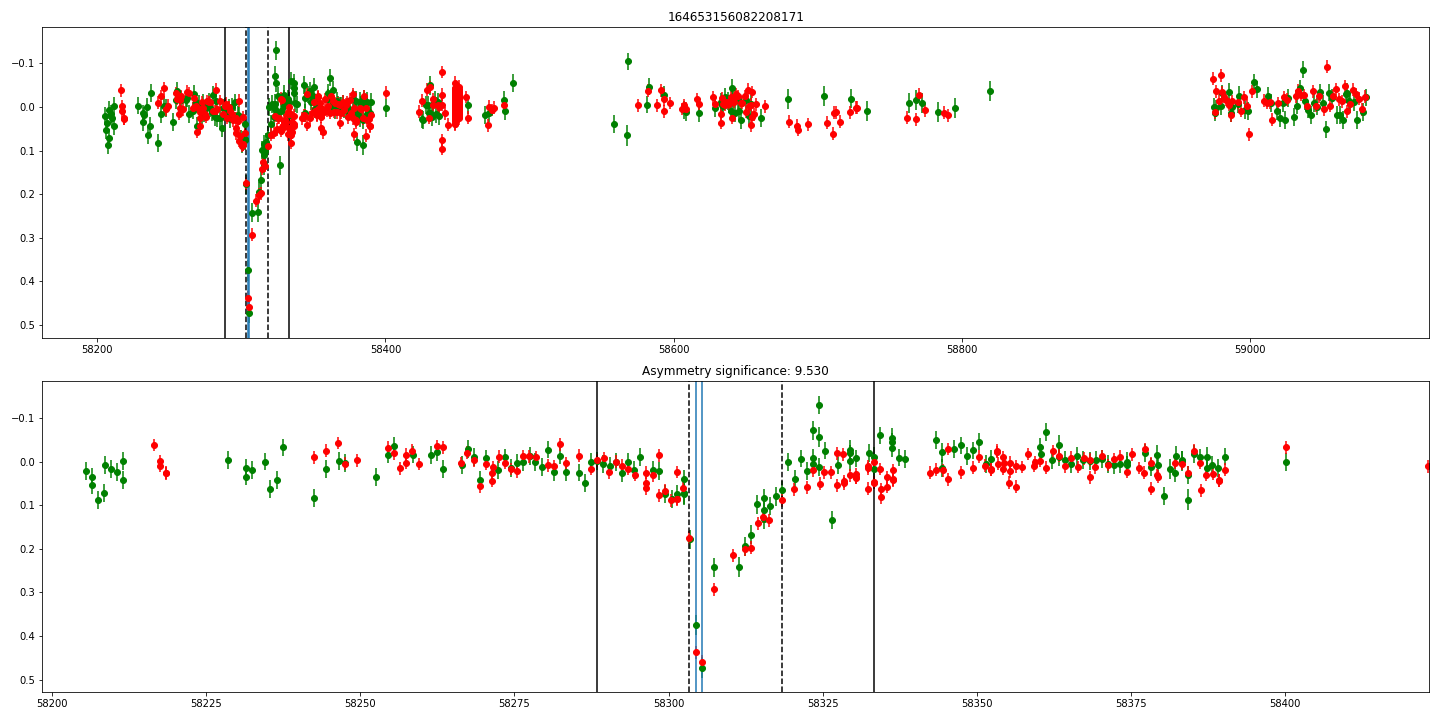

105370976834353455 2


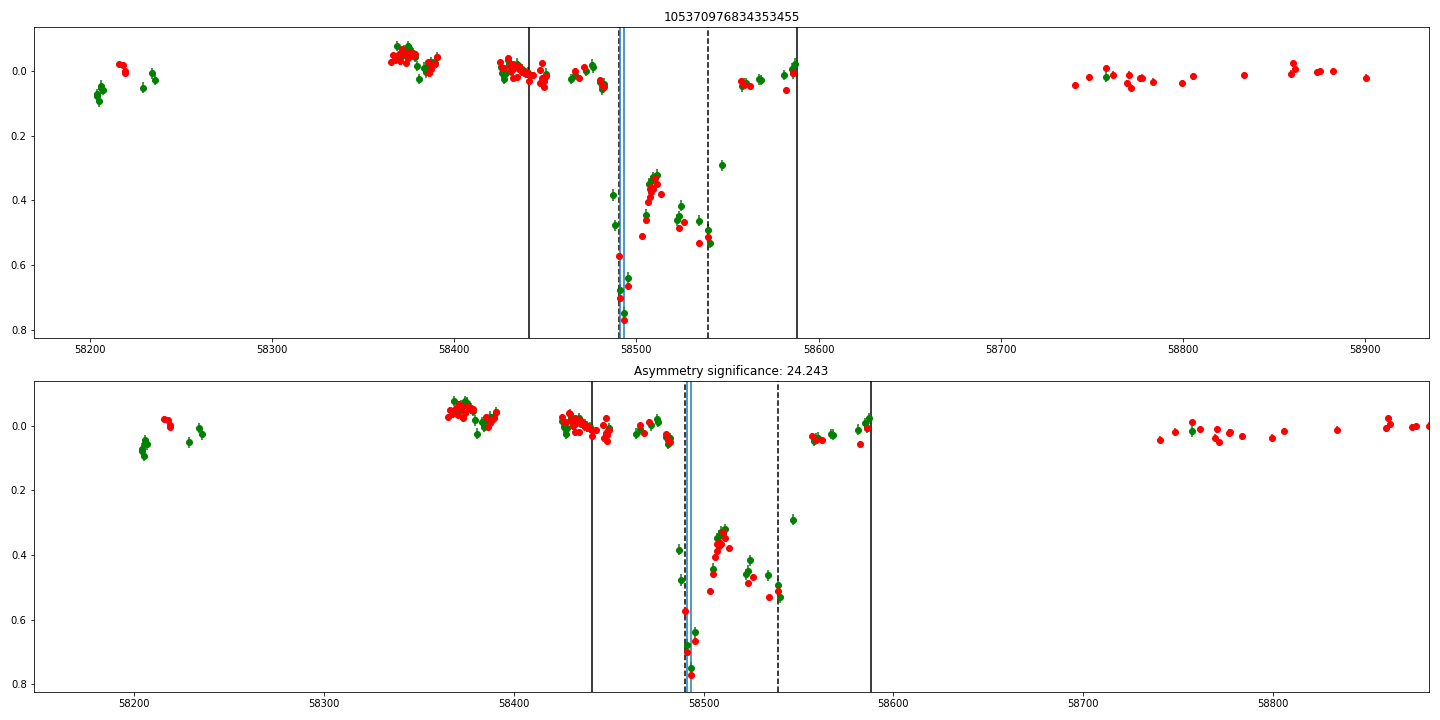

139092829523868897 2


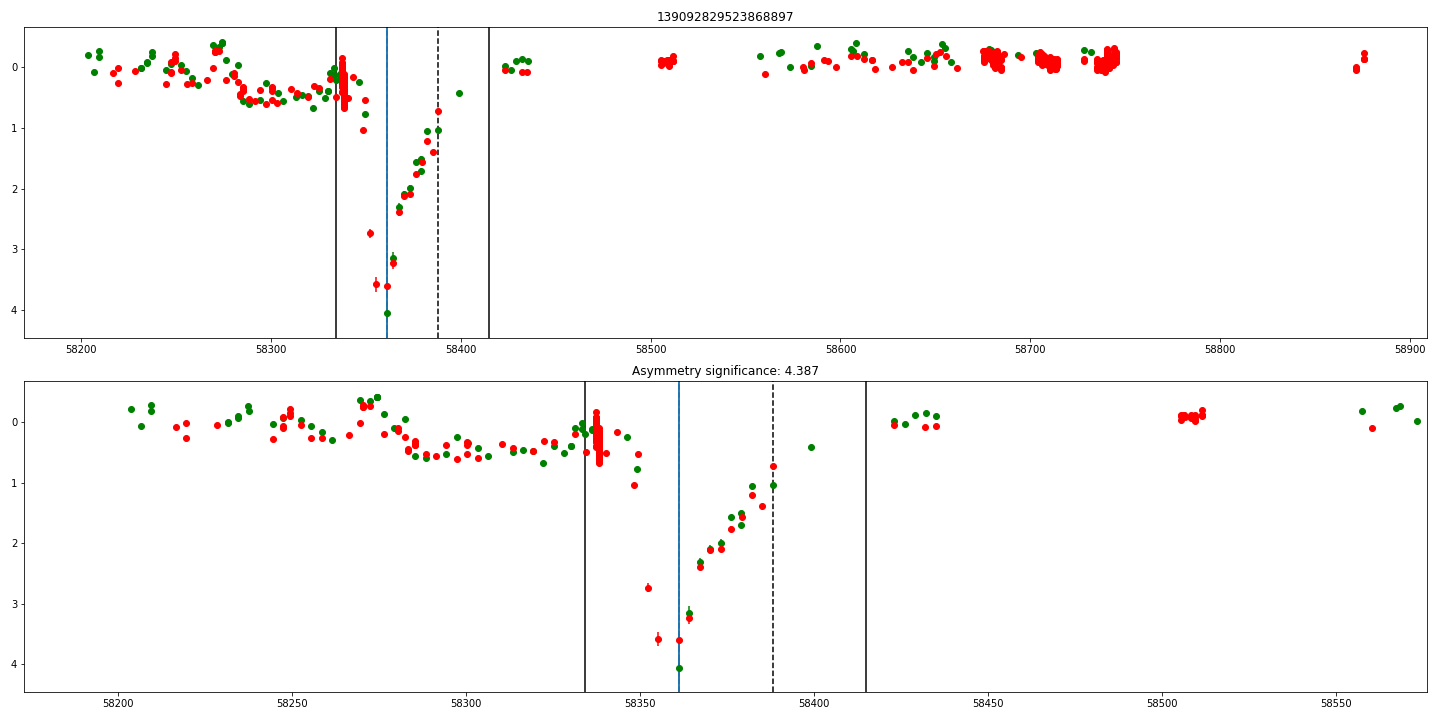

144130880928041281 2


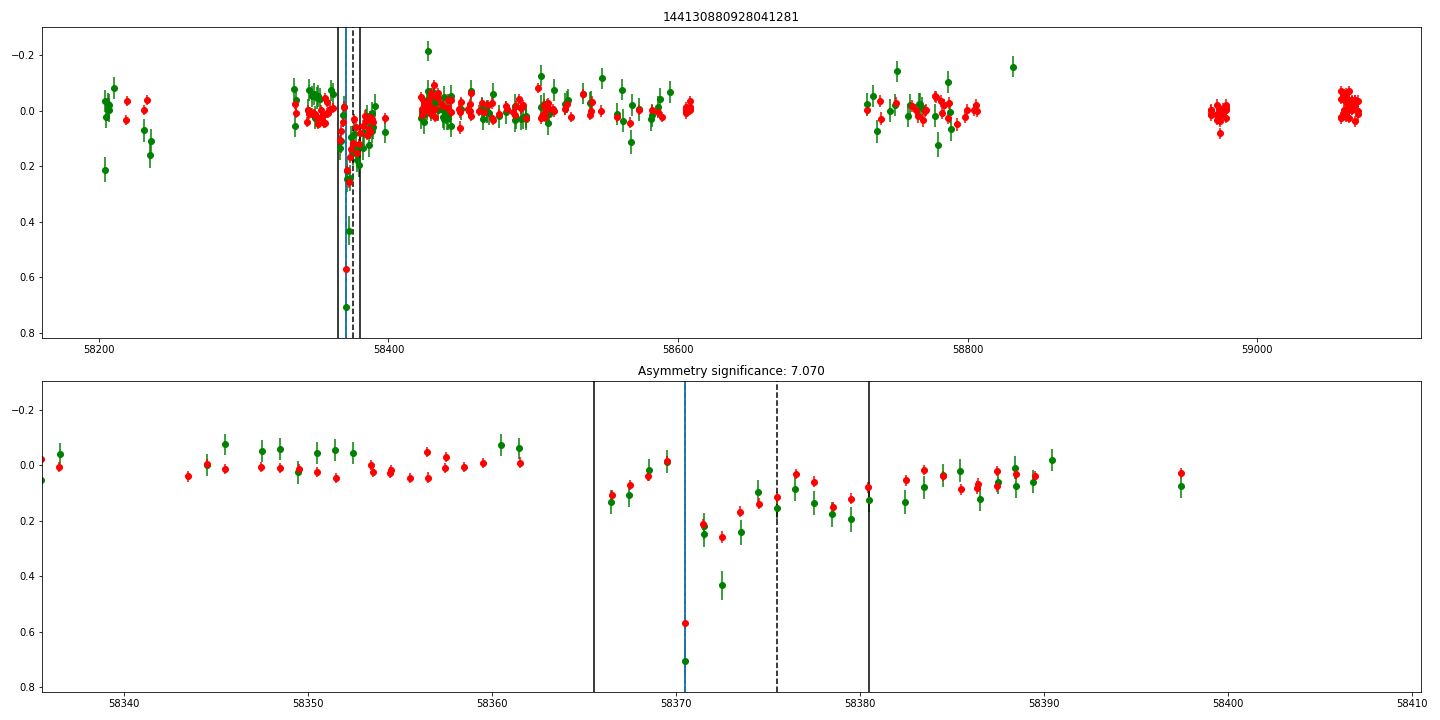

100582959343631974 2


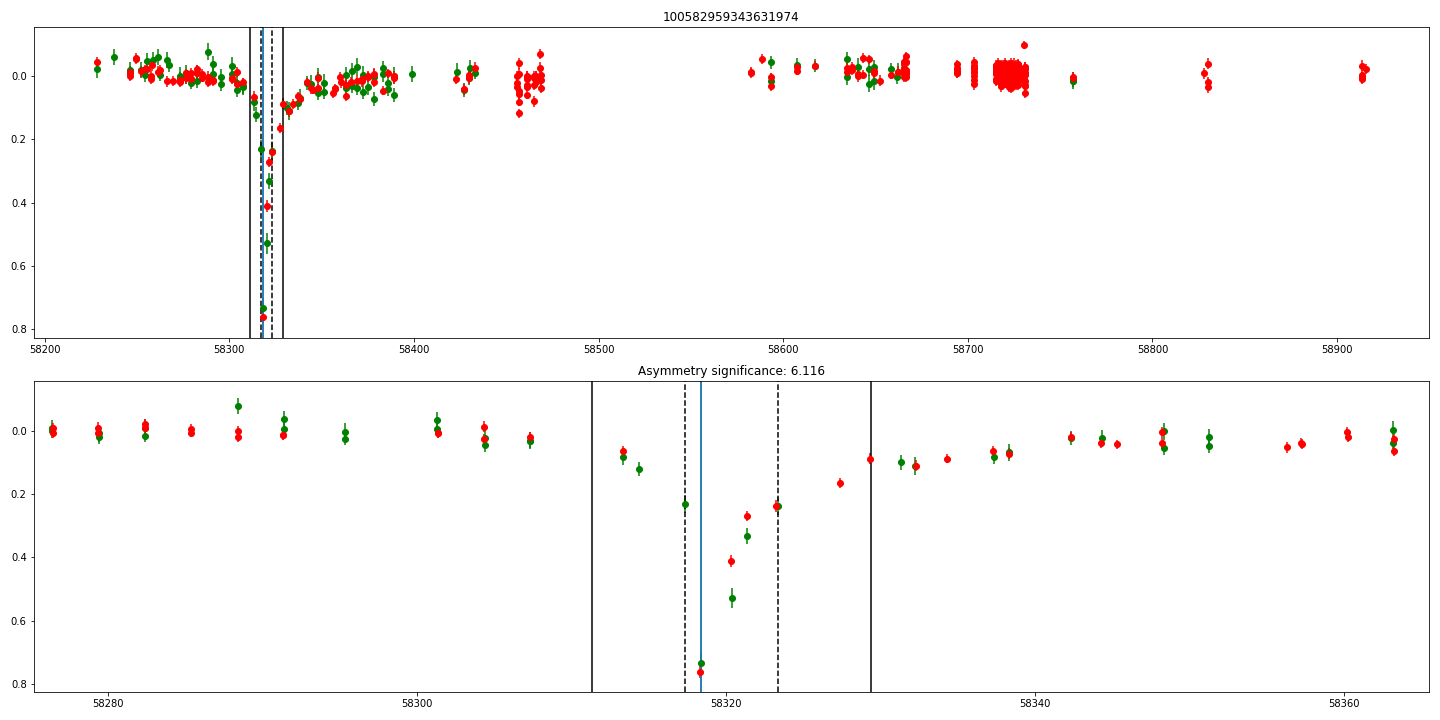

173453595098656338 1


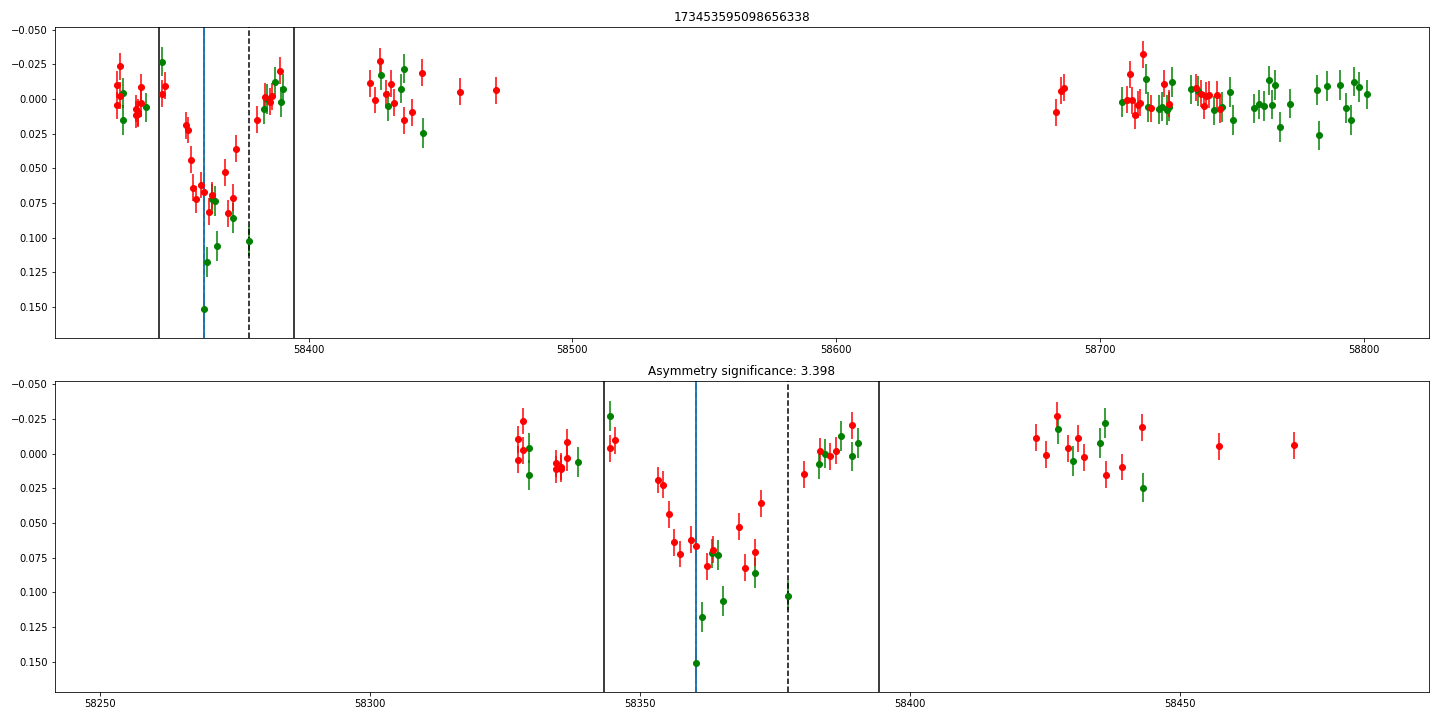

173260619709112041 1


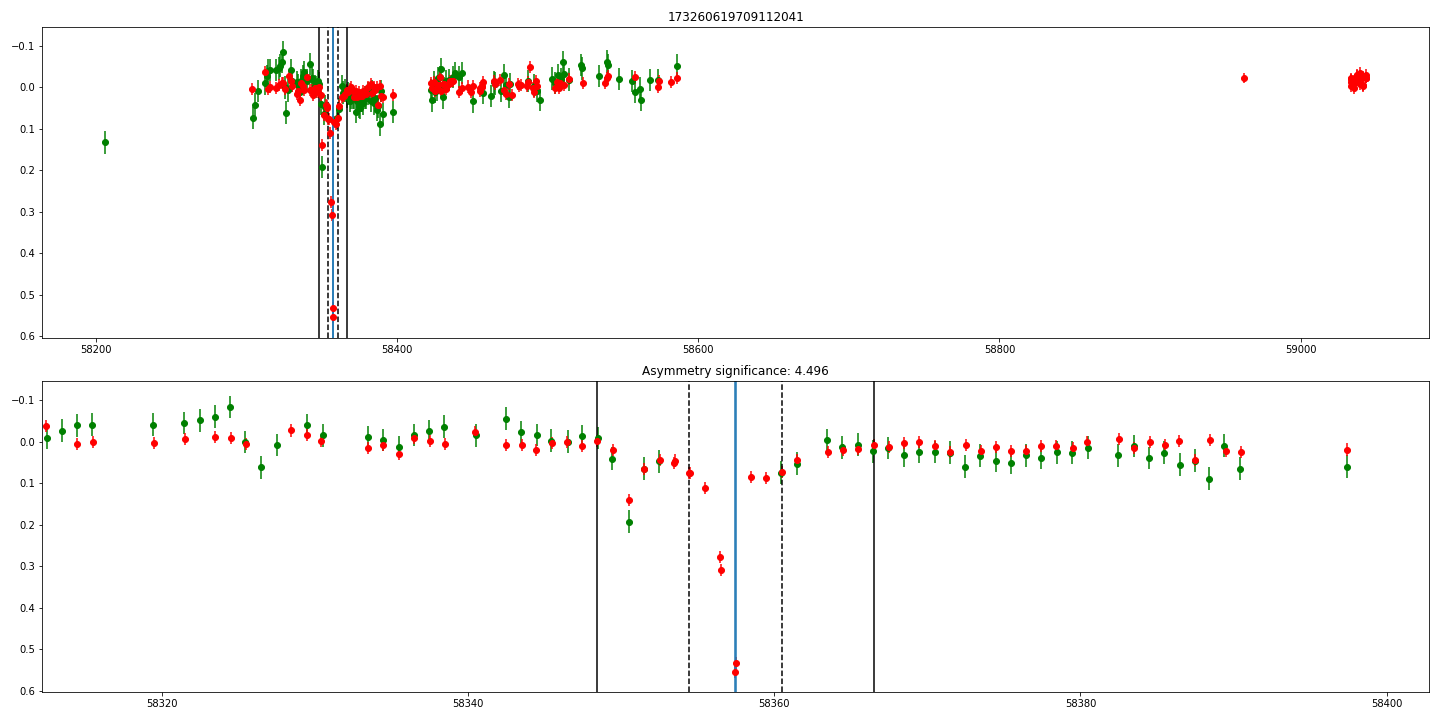

149633039908451296 1


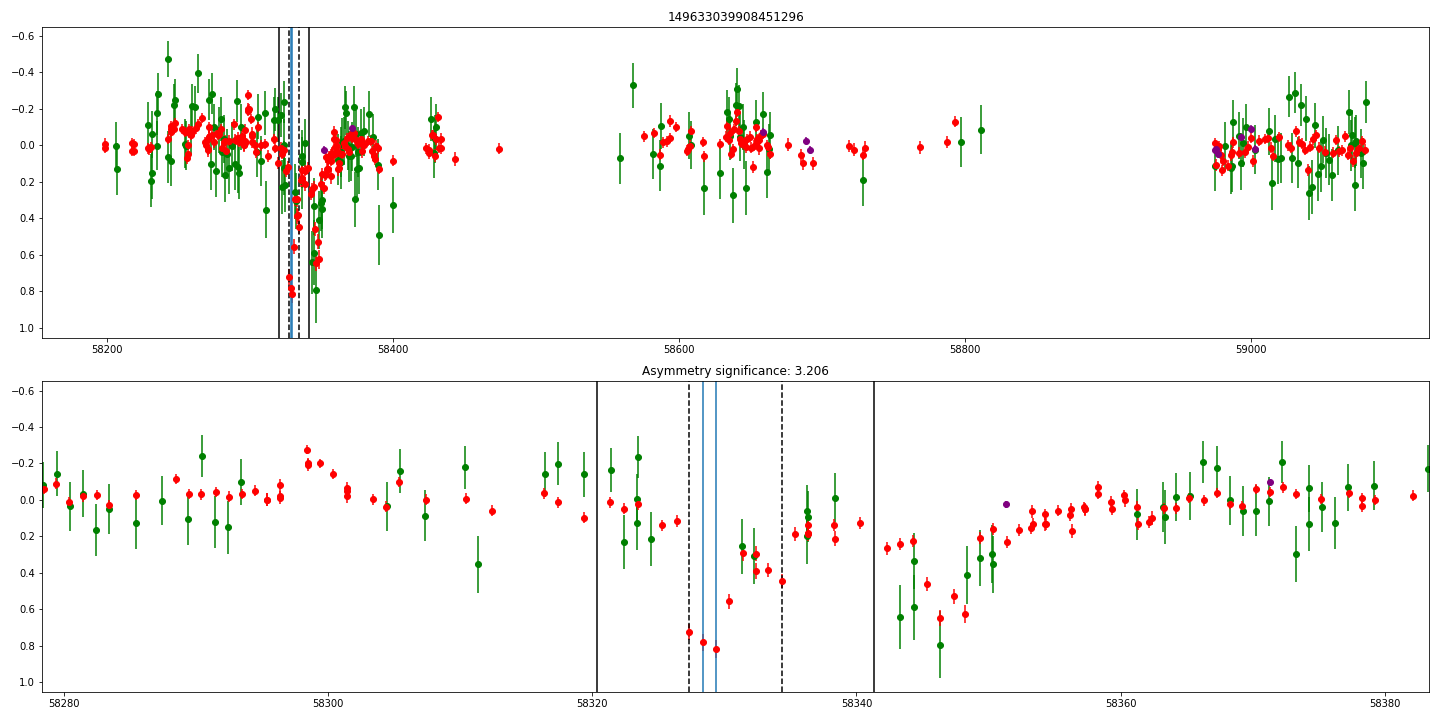

164683281281642831 1


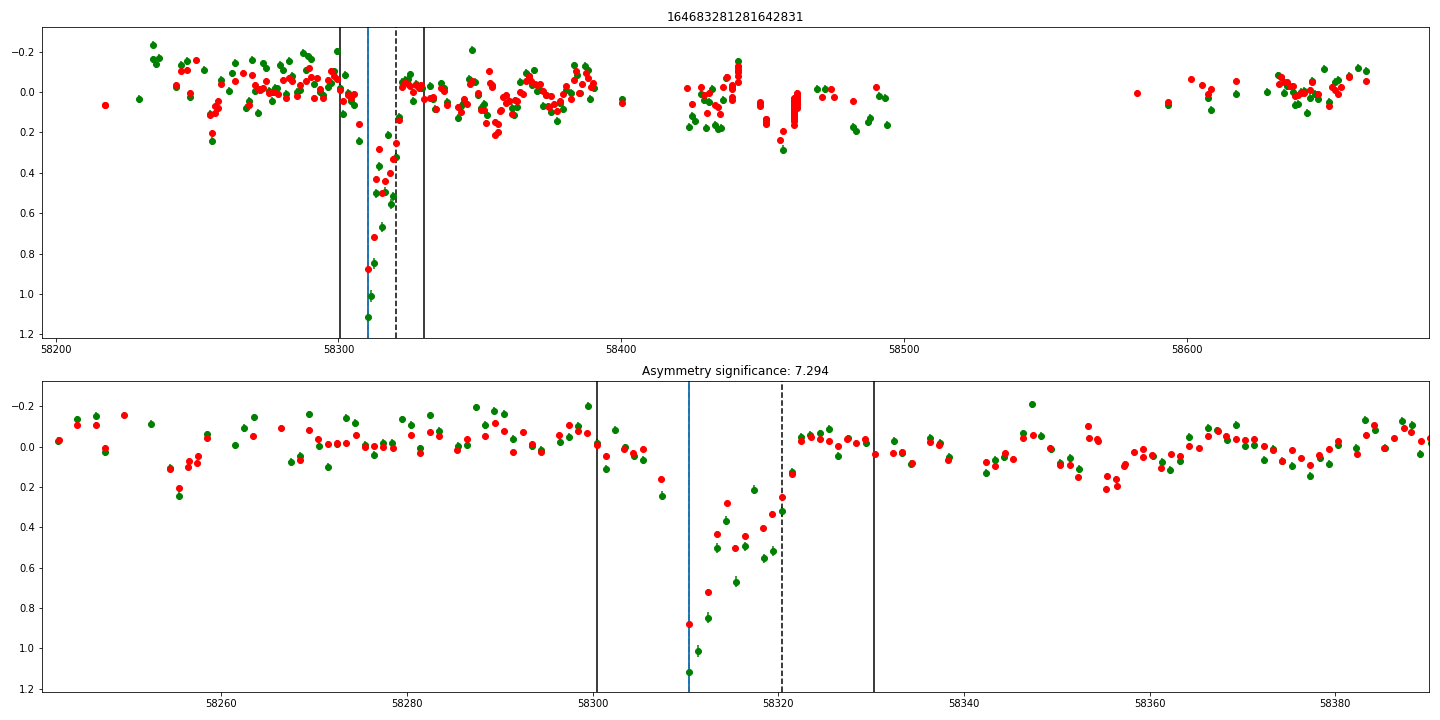

132762755591824101 1


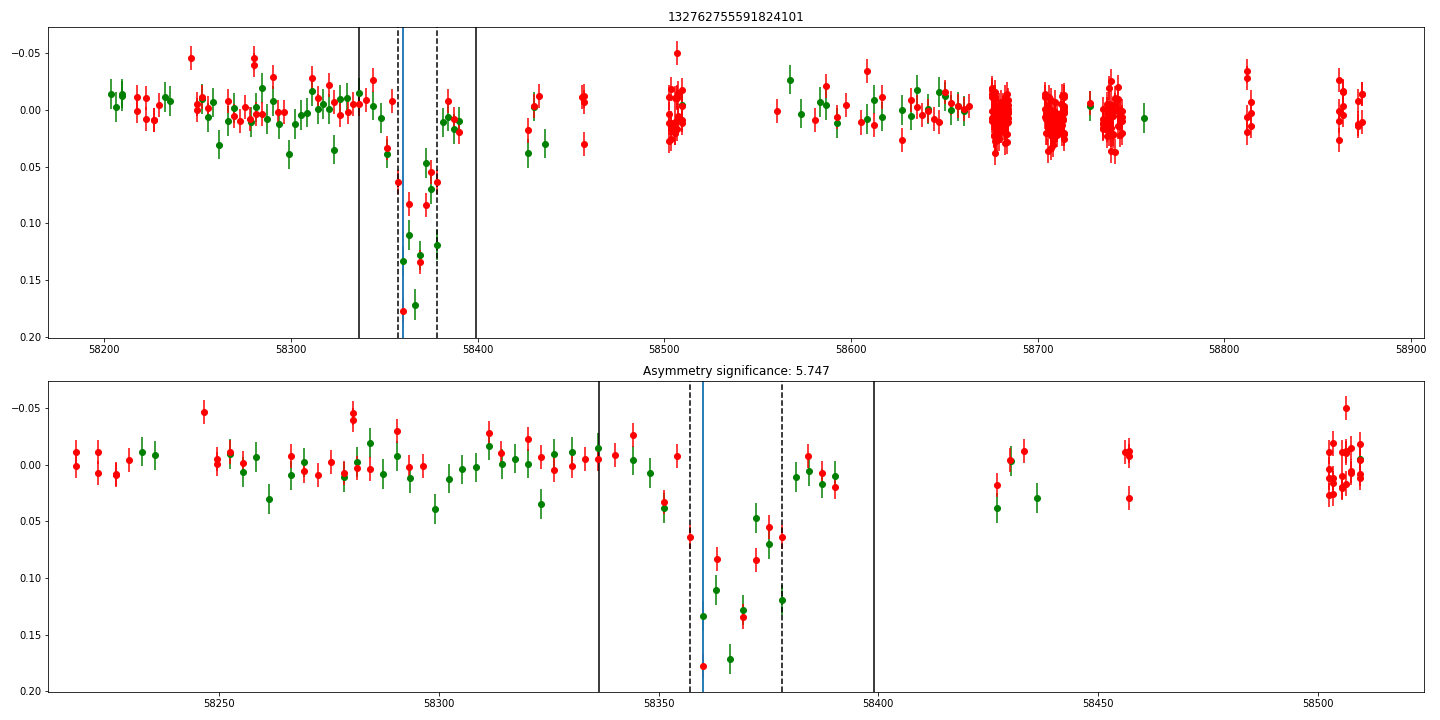

174390256734249897 1


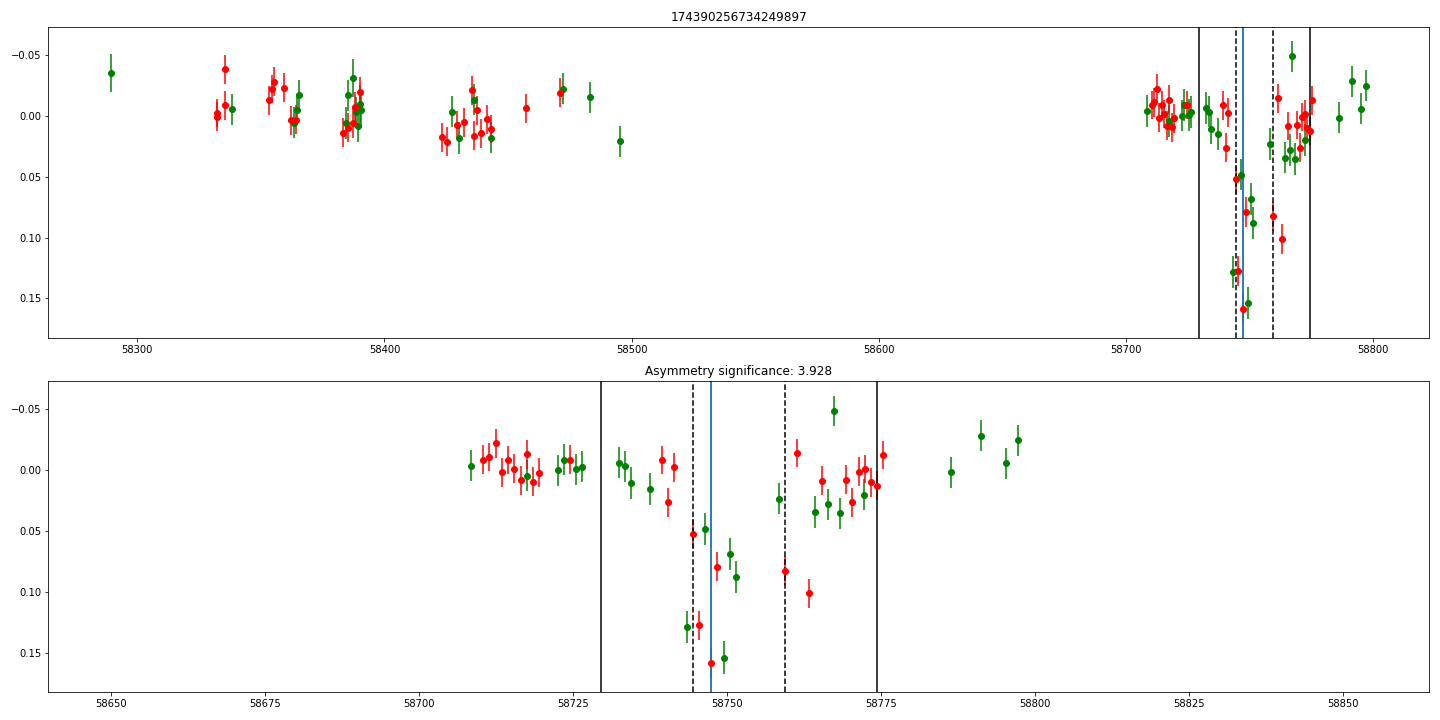

126442877393679193 1


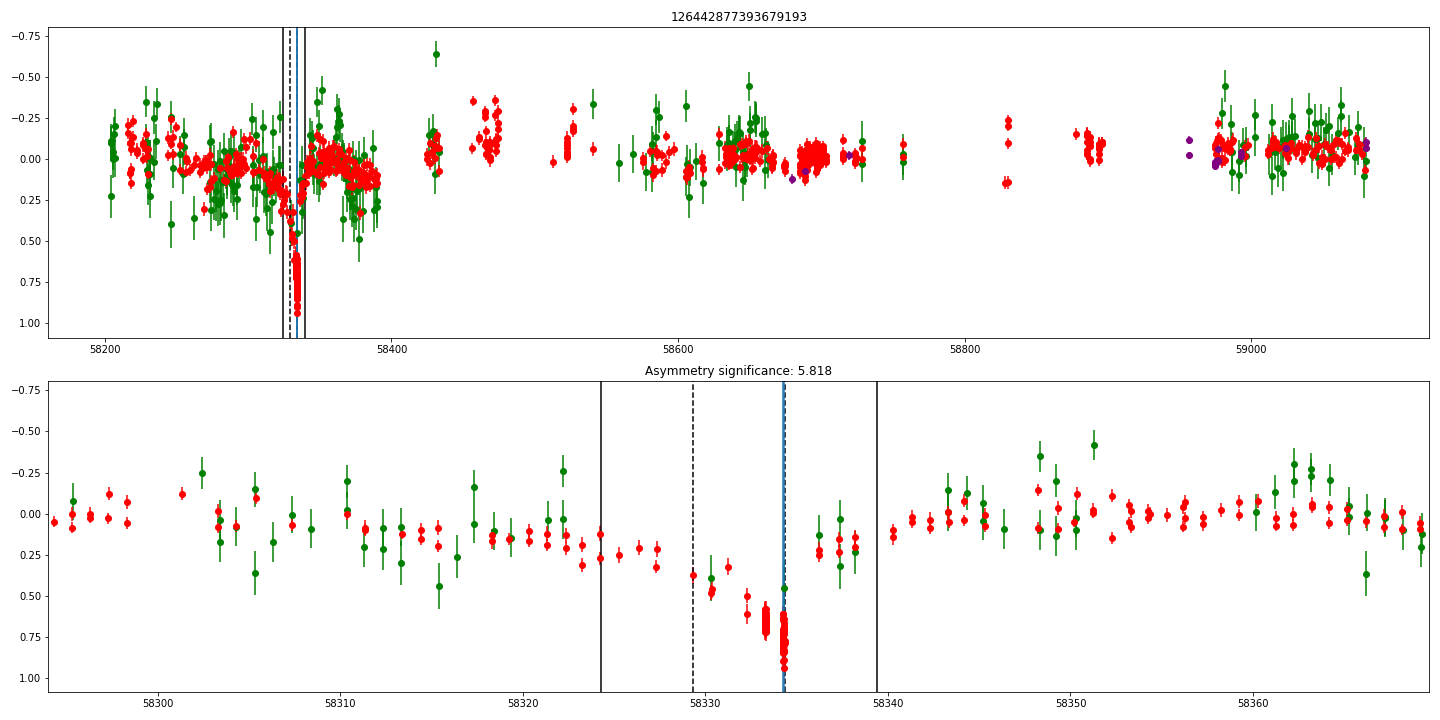

92832901014110779 1


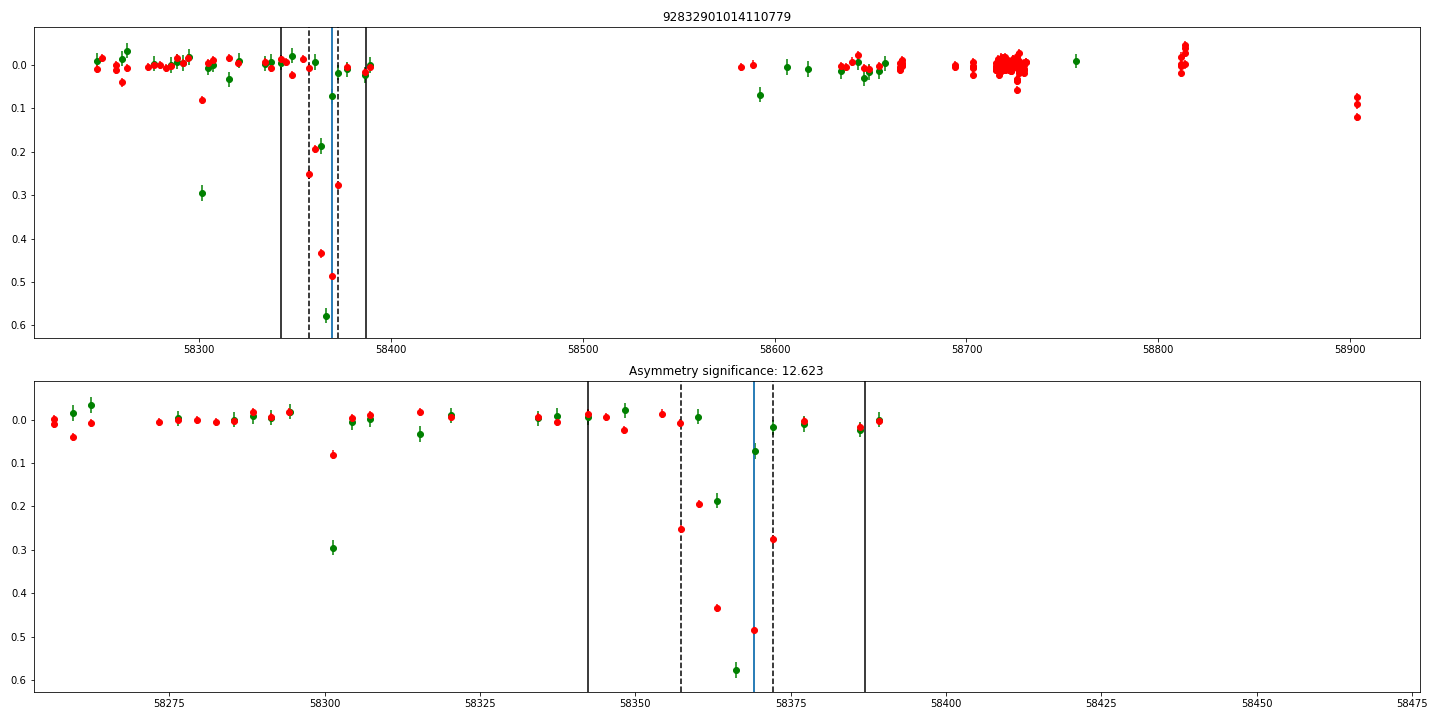

110852855969854057 1


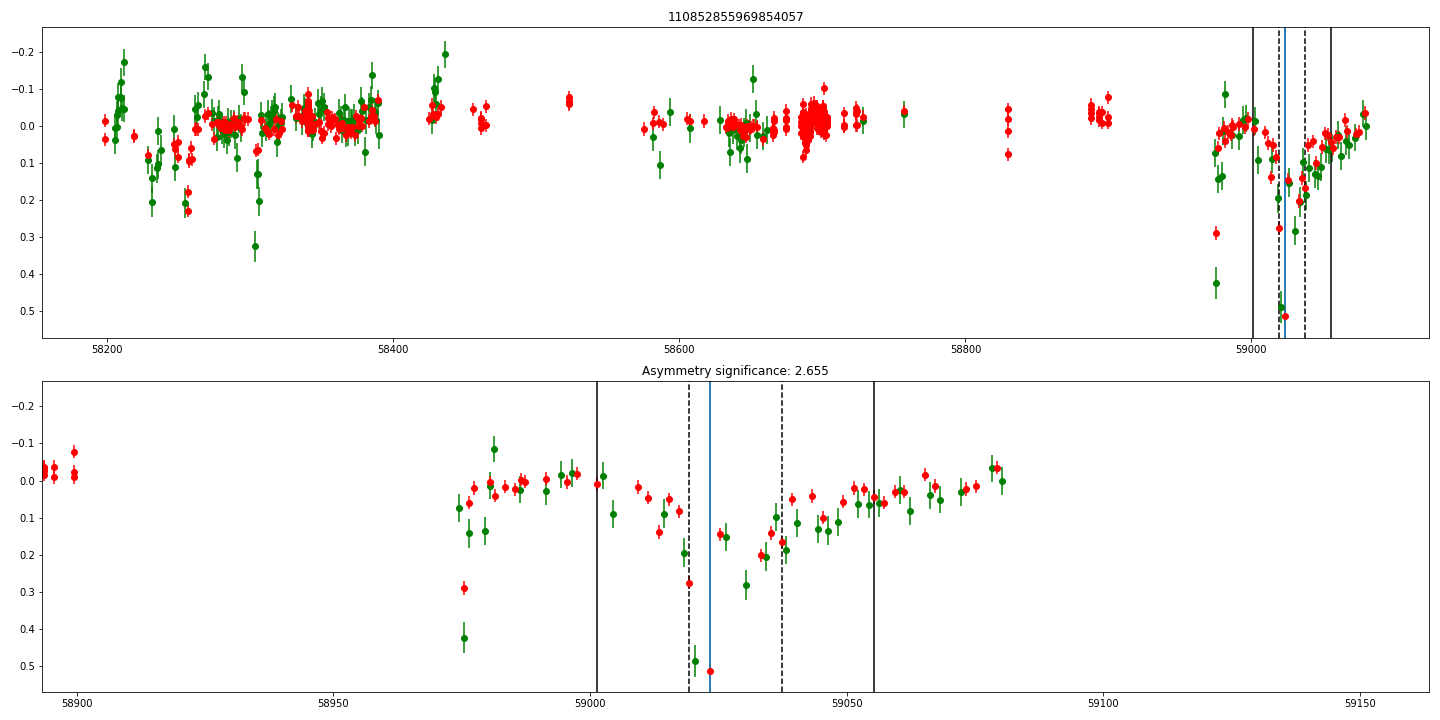

144022996188556147 1


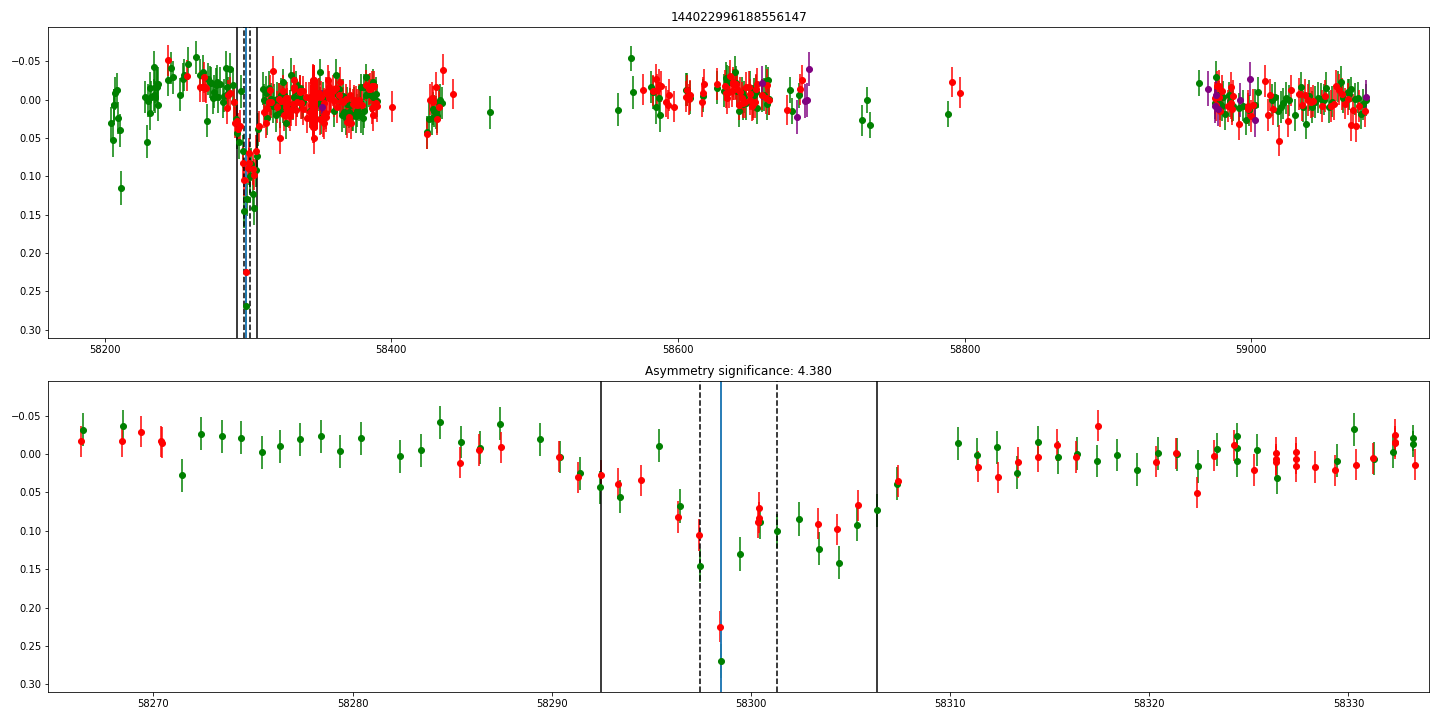

167983111466390337 1


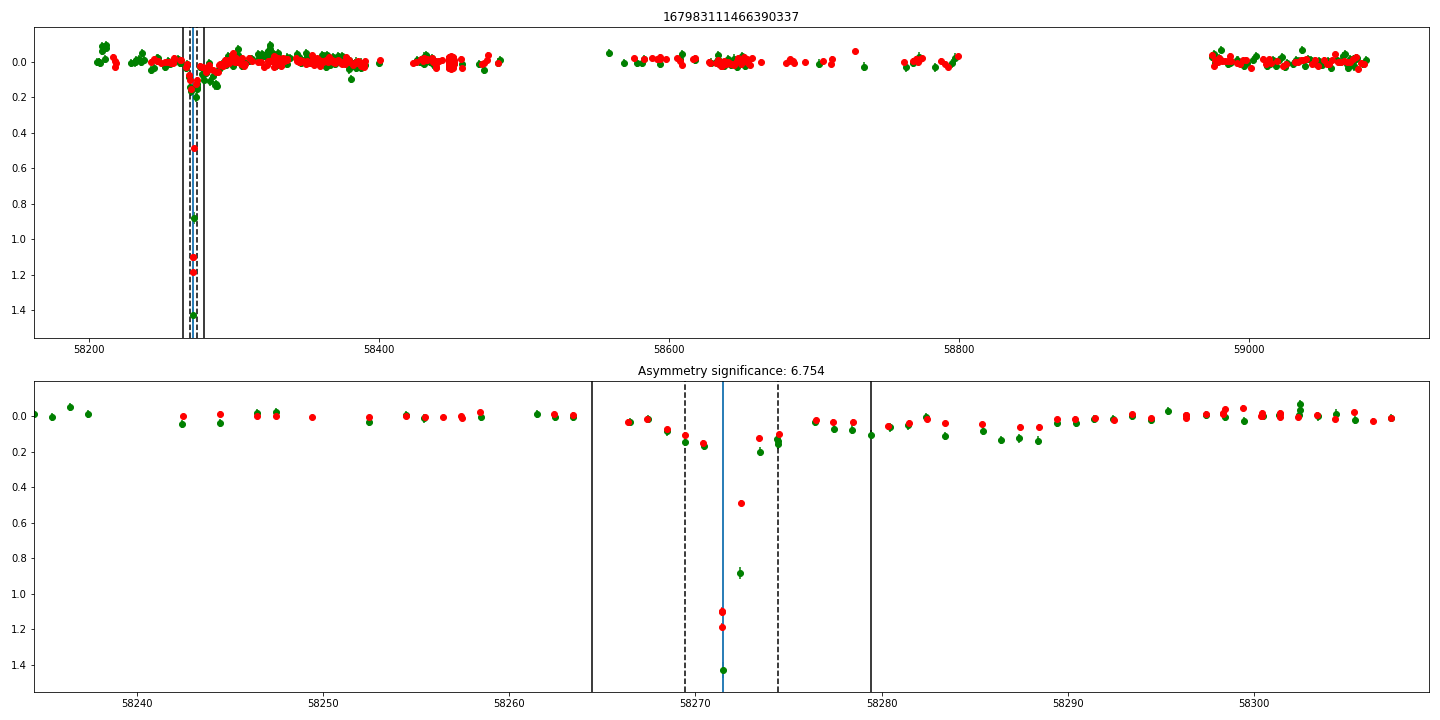

179453445347429323 1


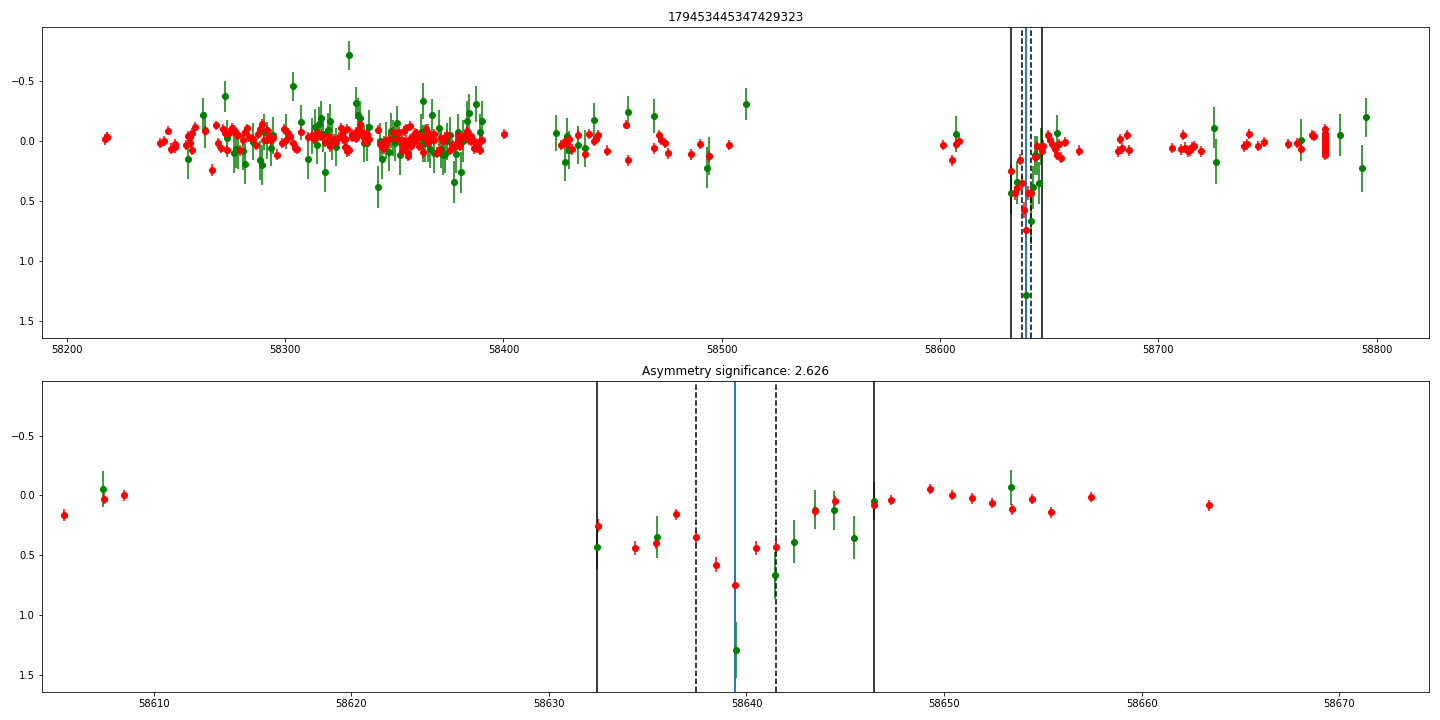

95342700219425059 1


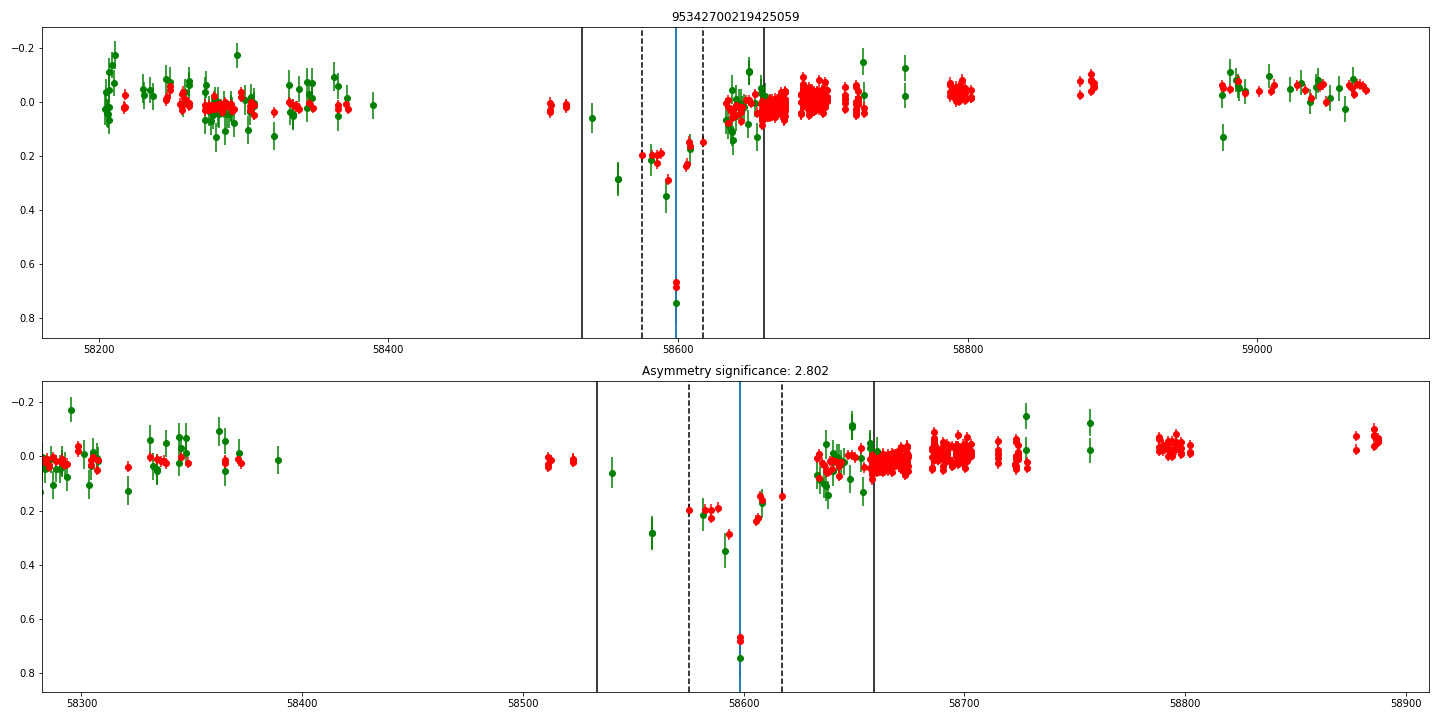

130953164725673763 1


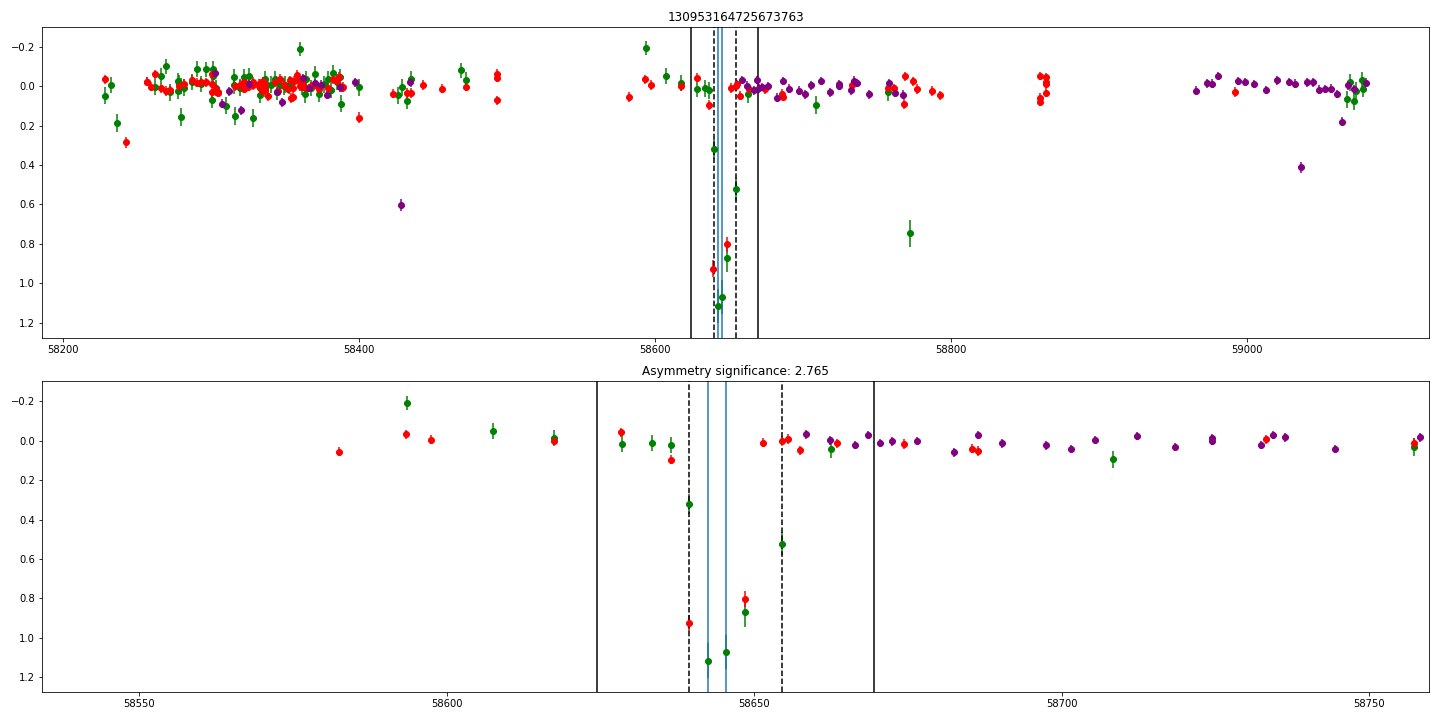

179030313136257708 1


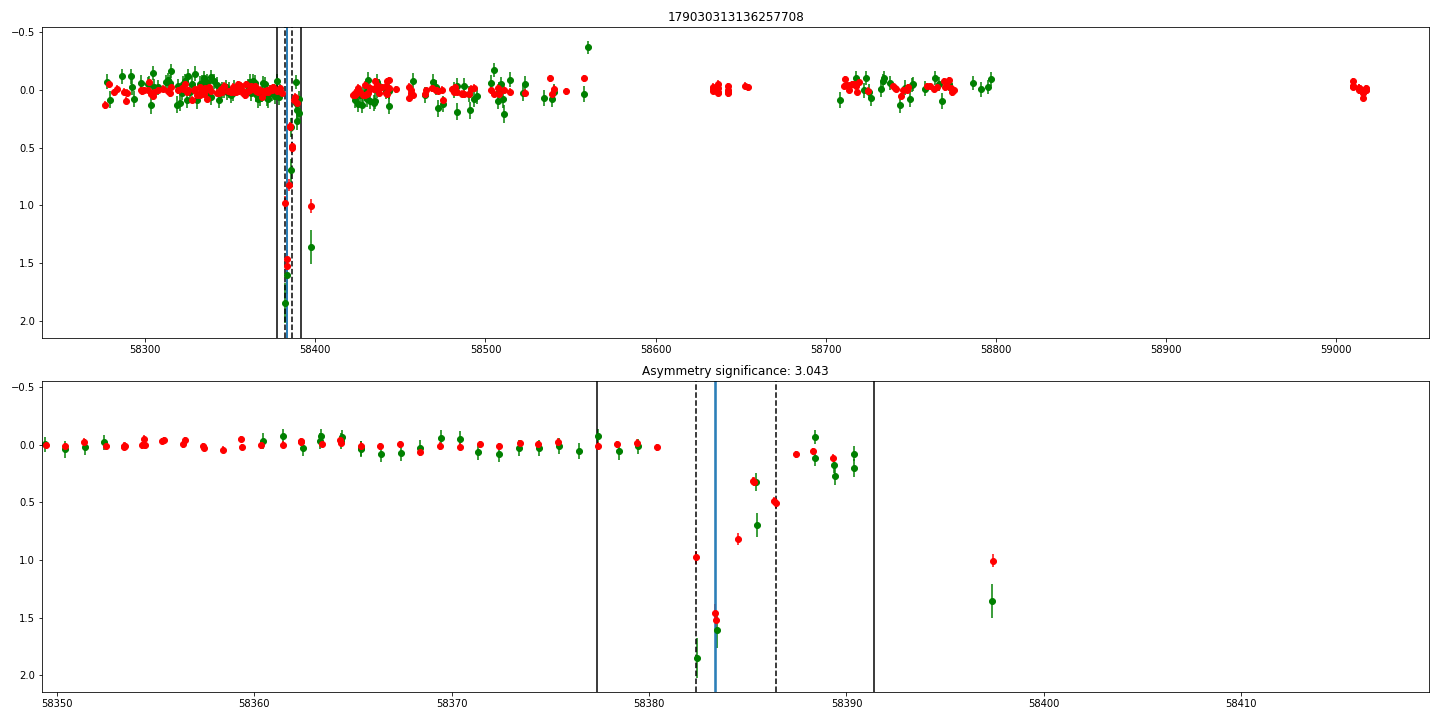

169420489540361407 1


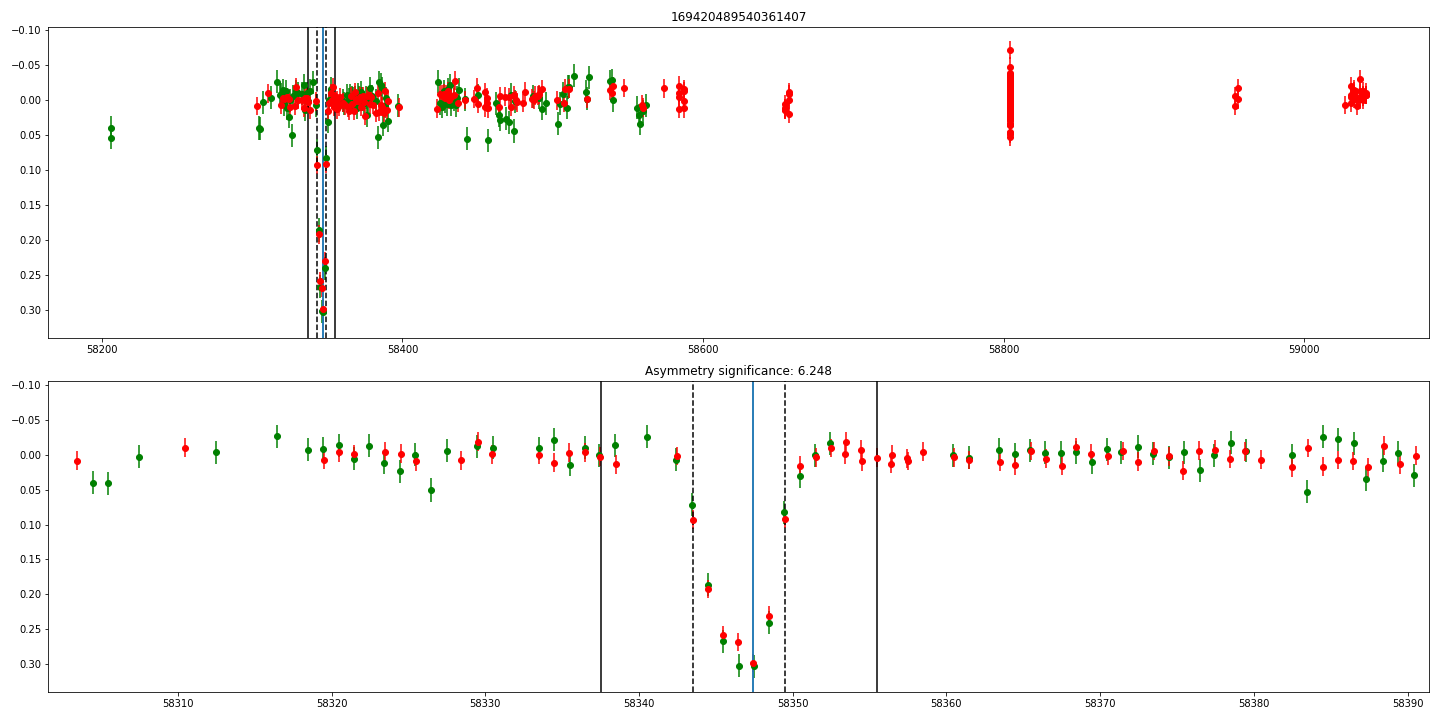

99712689129200776 1


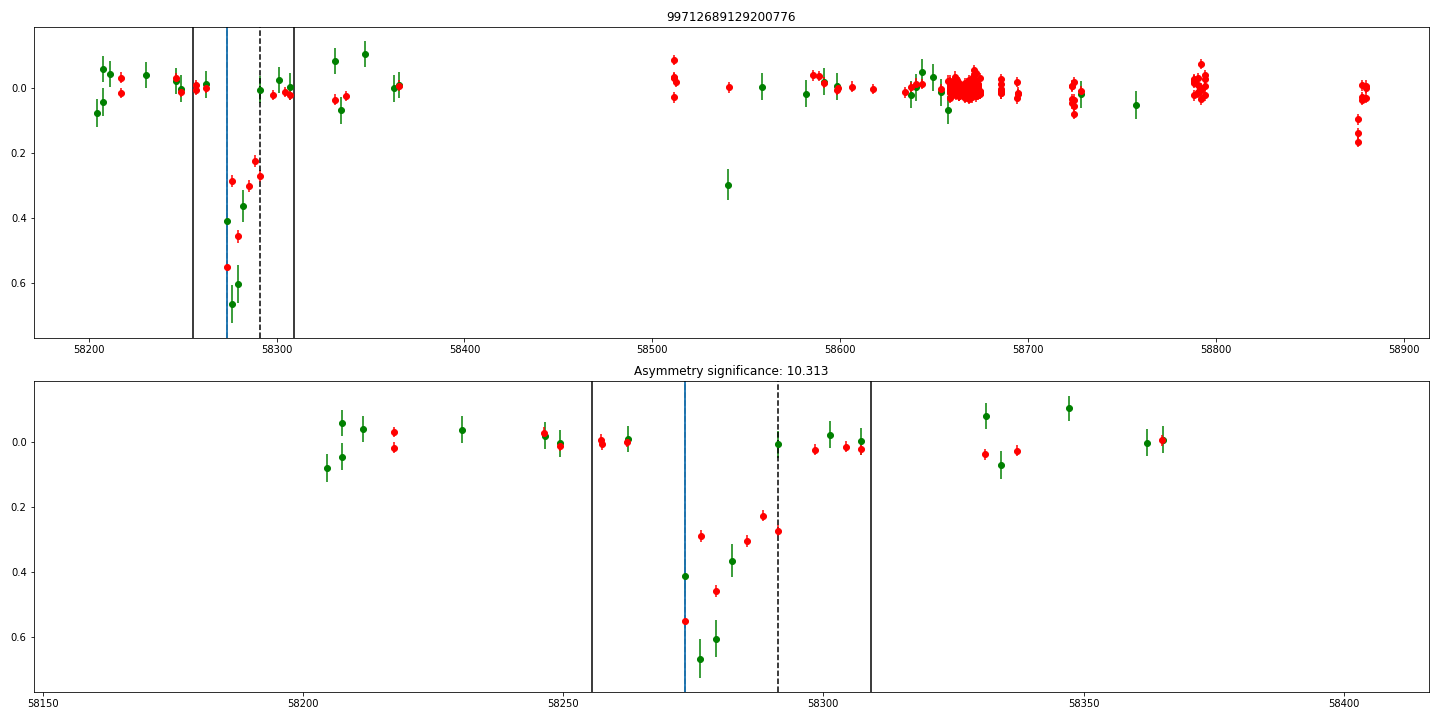

168433257951352509 1


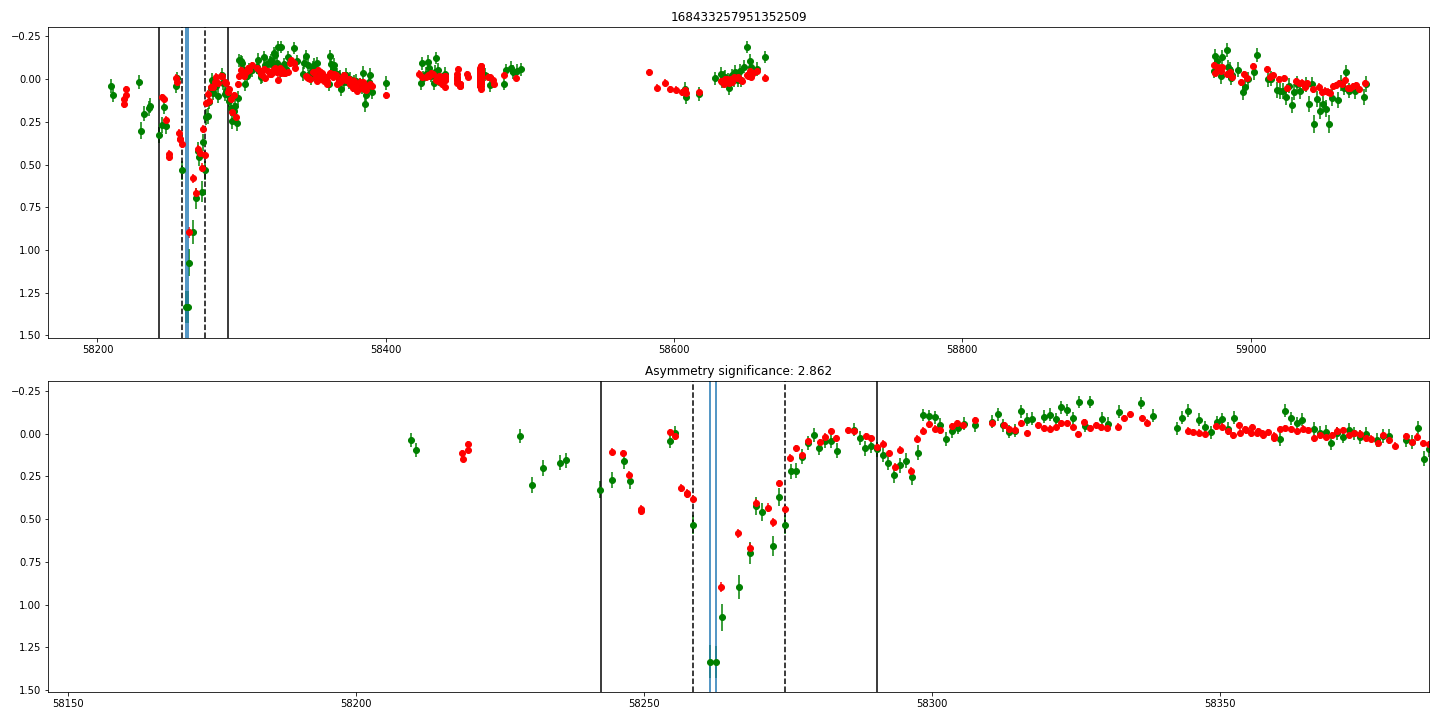

In [23]:
for ps1_id, row in dfzoo.loc[wplatinum,'ps1_id'].value_counts().iteritems():
        print(ps1_id, row)
        display(Image(f'{image_dir}/{ps1_id}.png'))

## Gold sample: flat outside, could be single band, asymmetric 

In [24]:
wgold = ((dfzoo['flat_outside_window'] == 'Yes') & 
        #((dfzoo['dip_both_bands'] == 'Yes') | 
         ((dfzoo['dip_both_bands'] == 'Not enough information to tell due to sampling.'))  
        & (dfzoo['asymmetric'] == 'Yes'))

In [25]:
np.sum(wgold)

10

143082996212776354 1


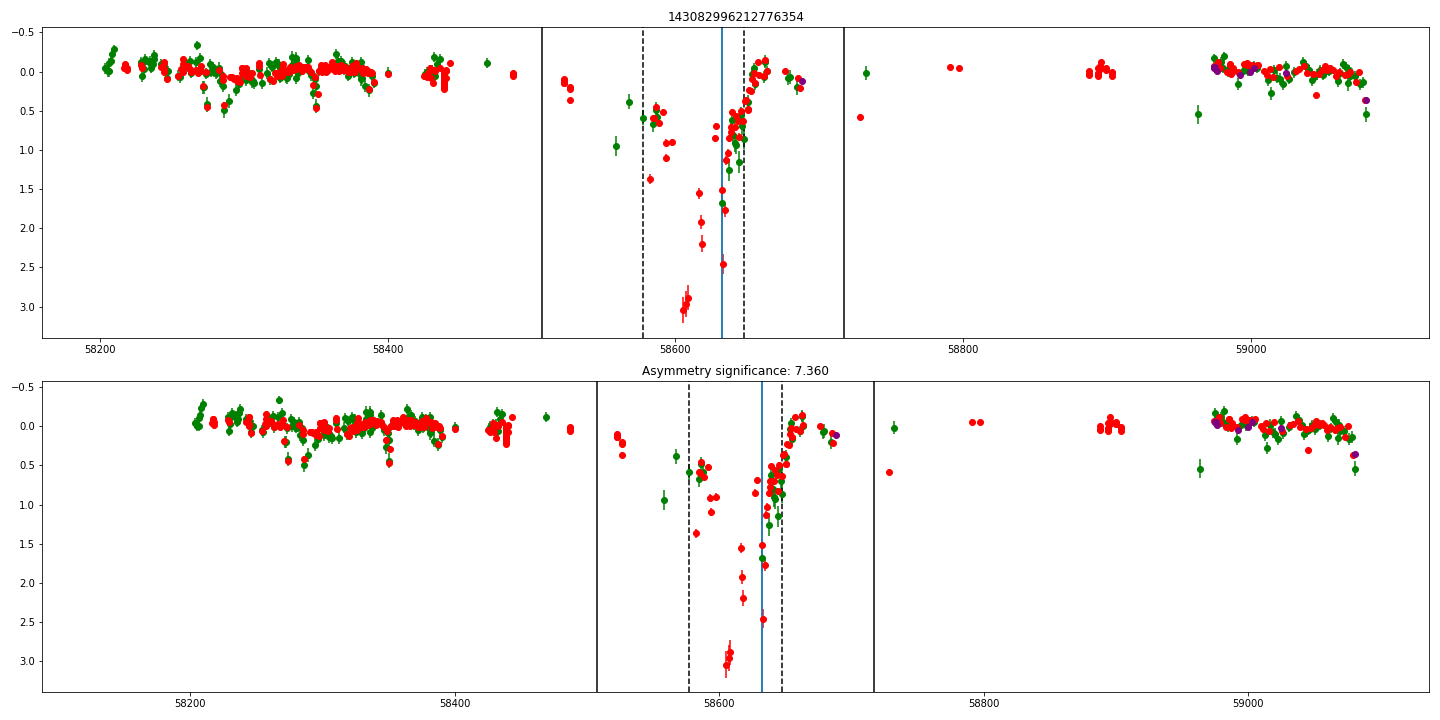

167260085796626634 1


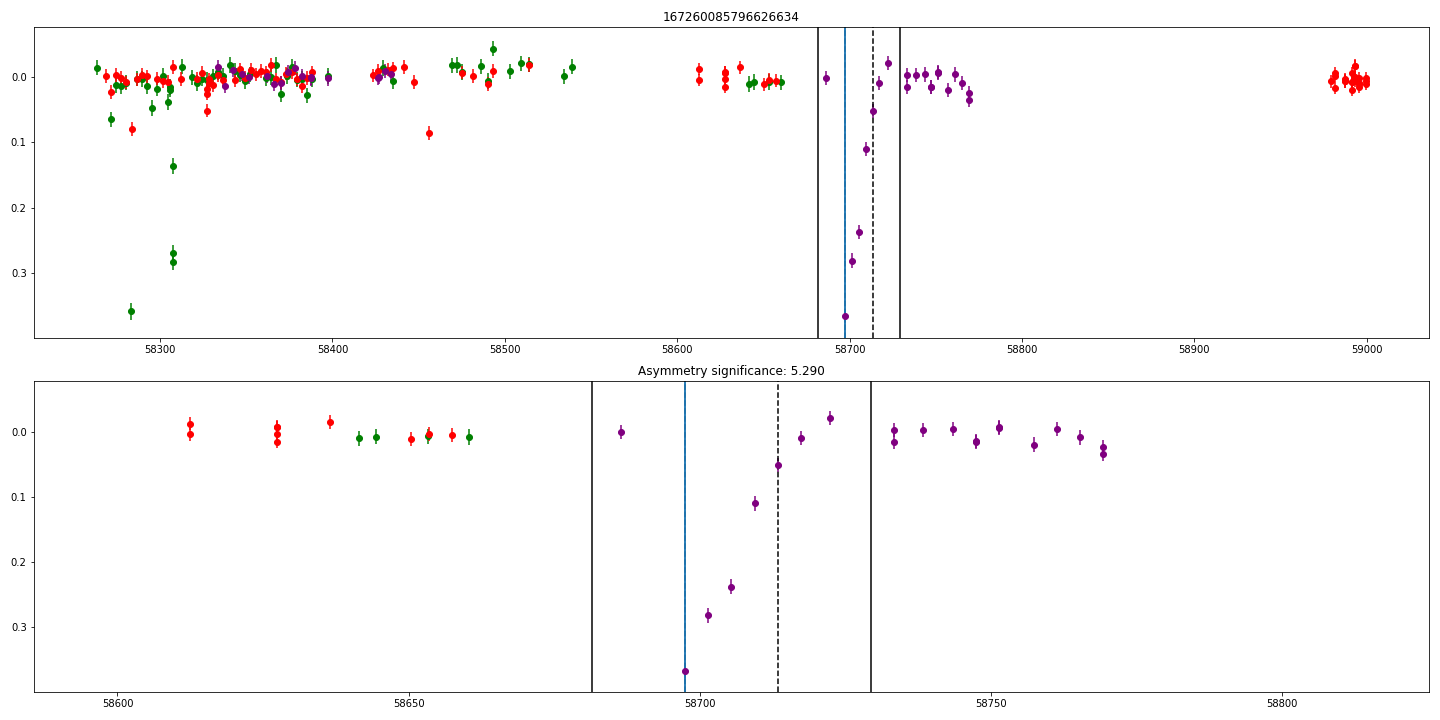

157263054040187240 1


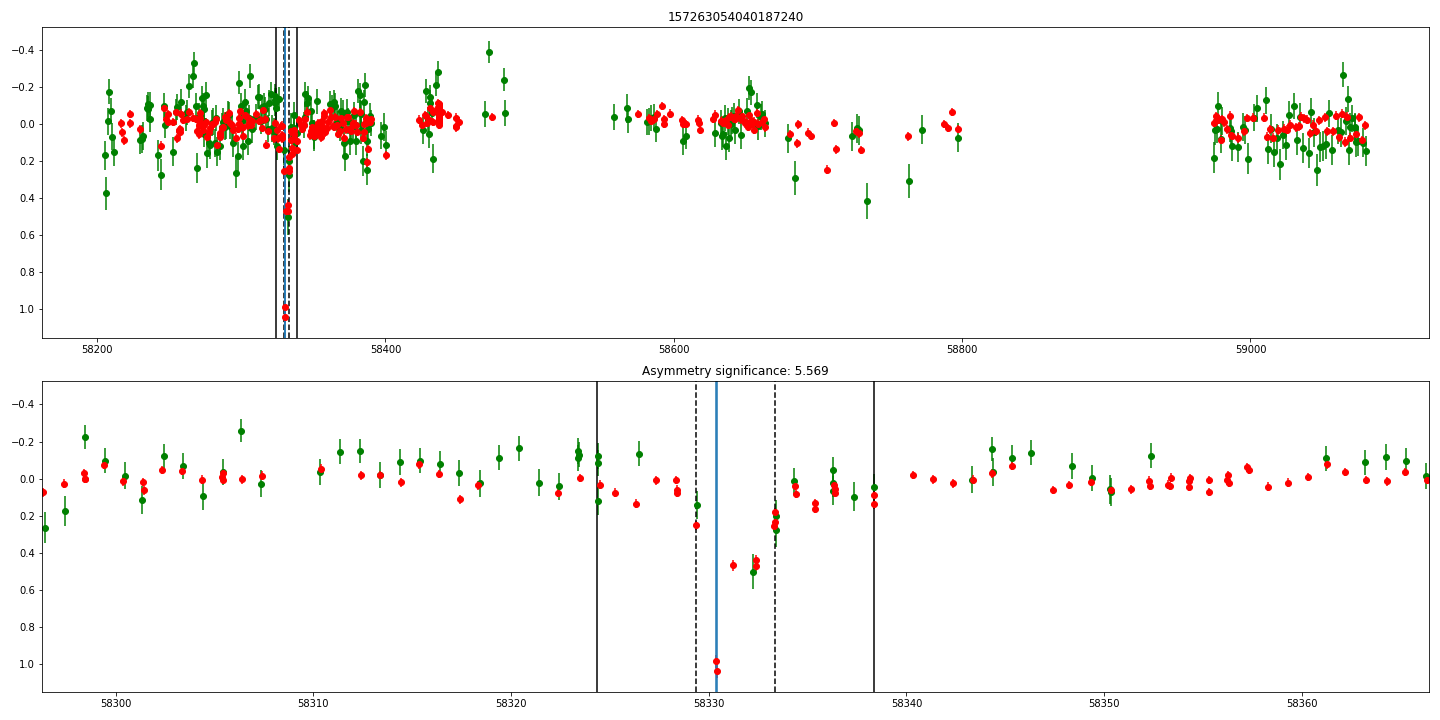

191370301570012472 1


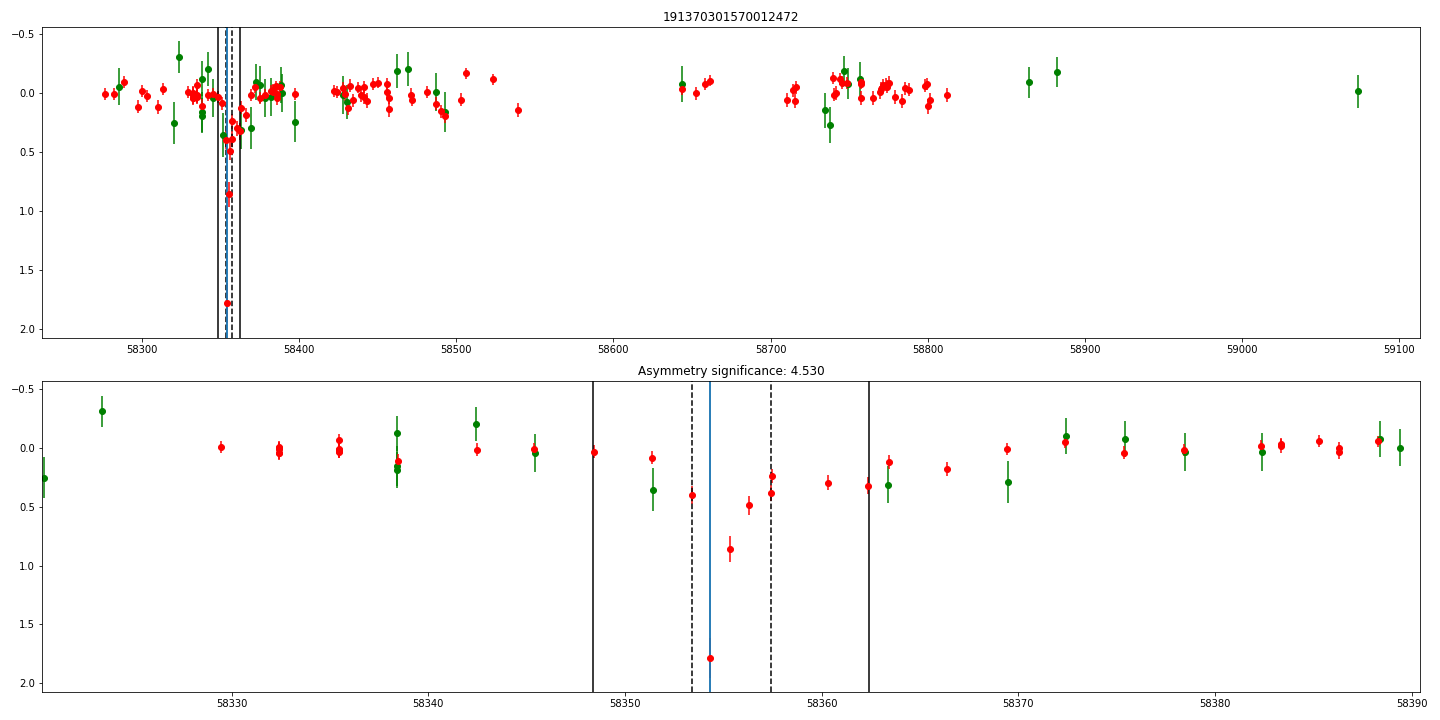

108682818948019907 1


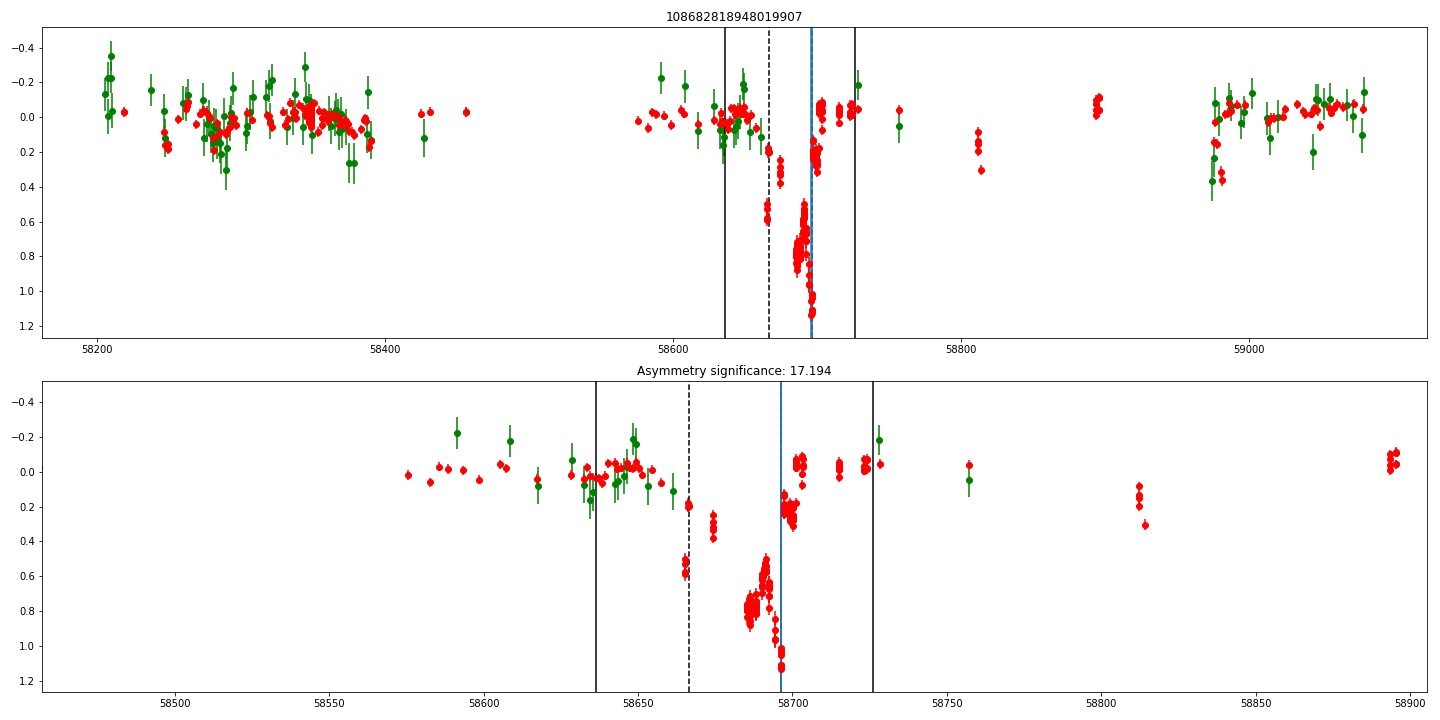

126442877393679193 1


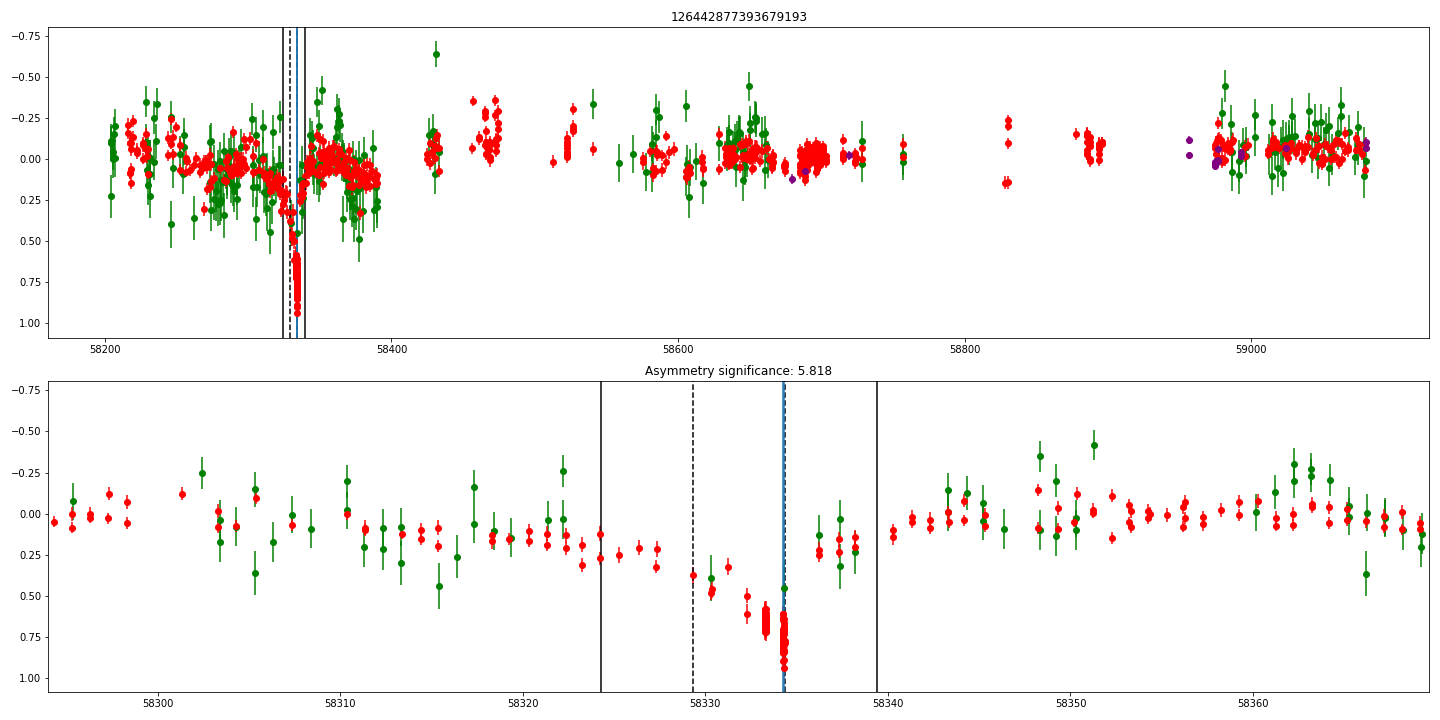

173260619709112041 1


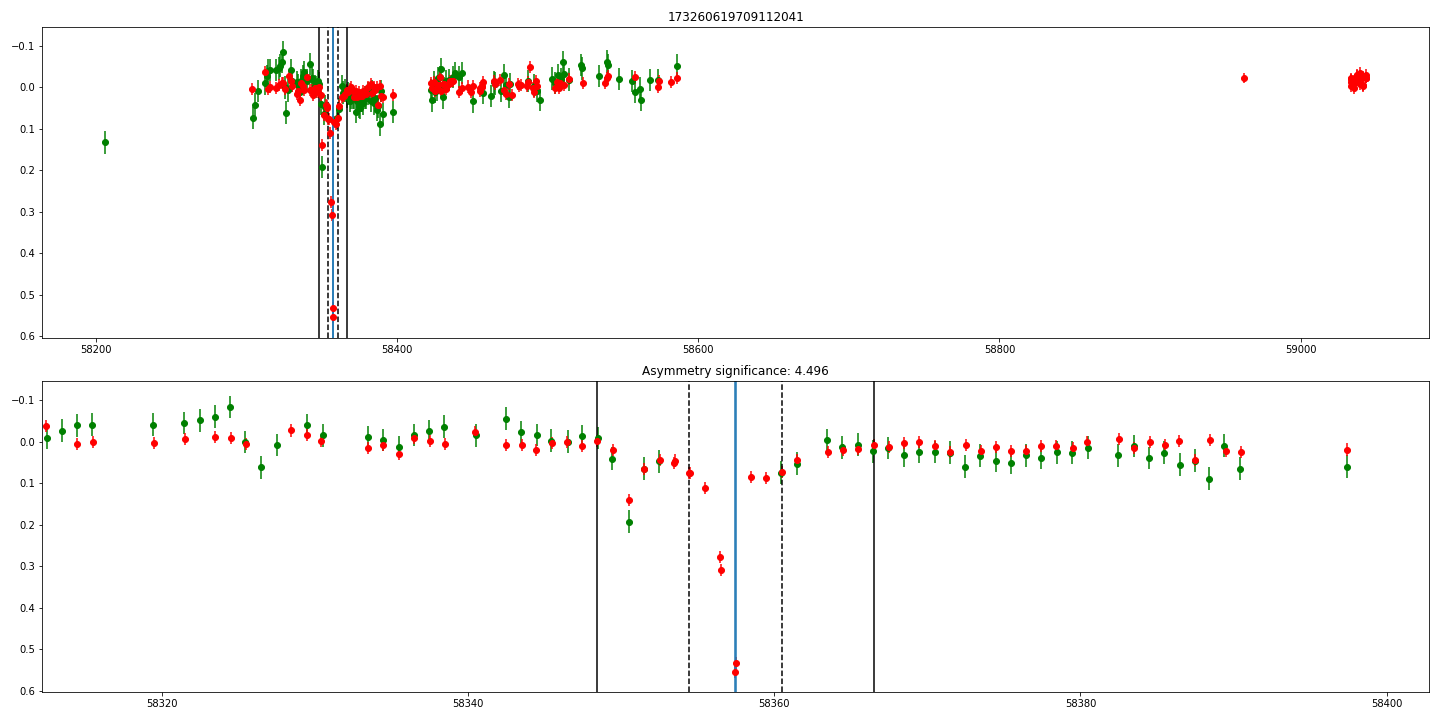

176460036548313279 1


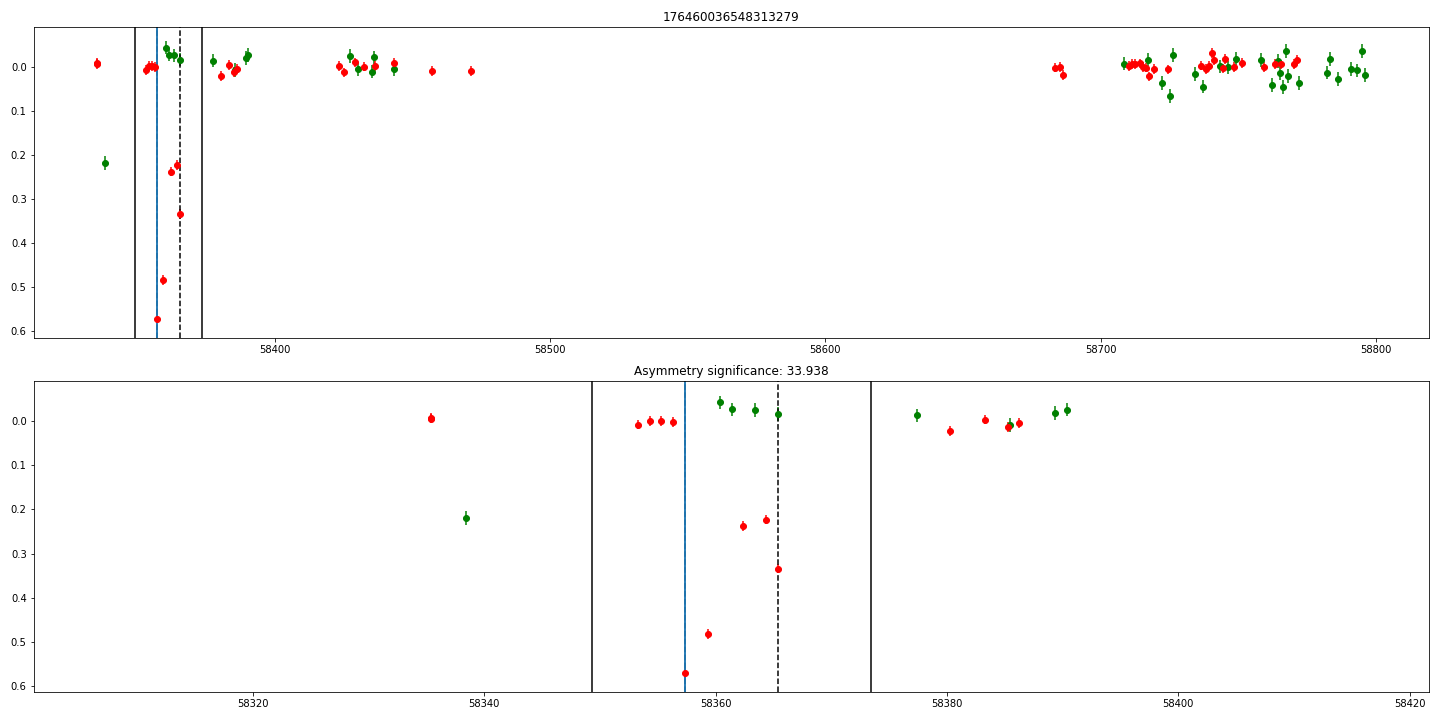

83532742759190744 1


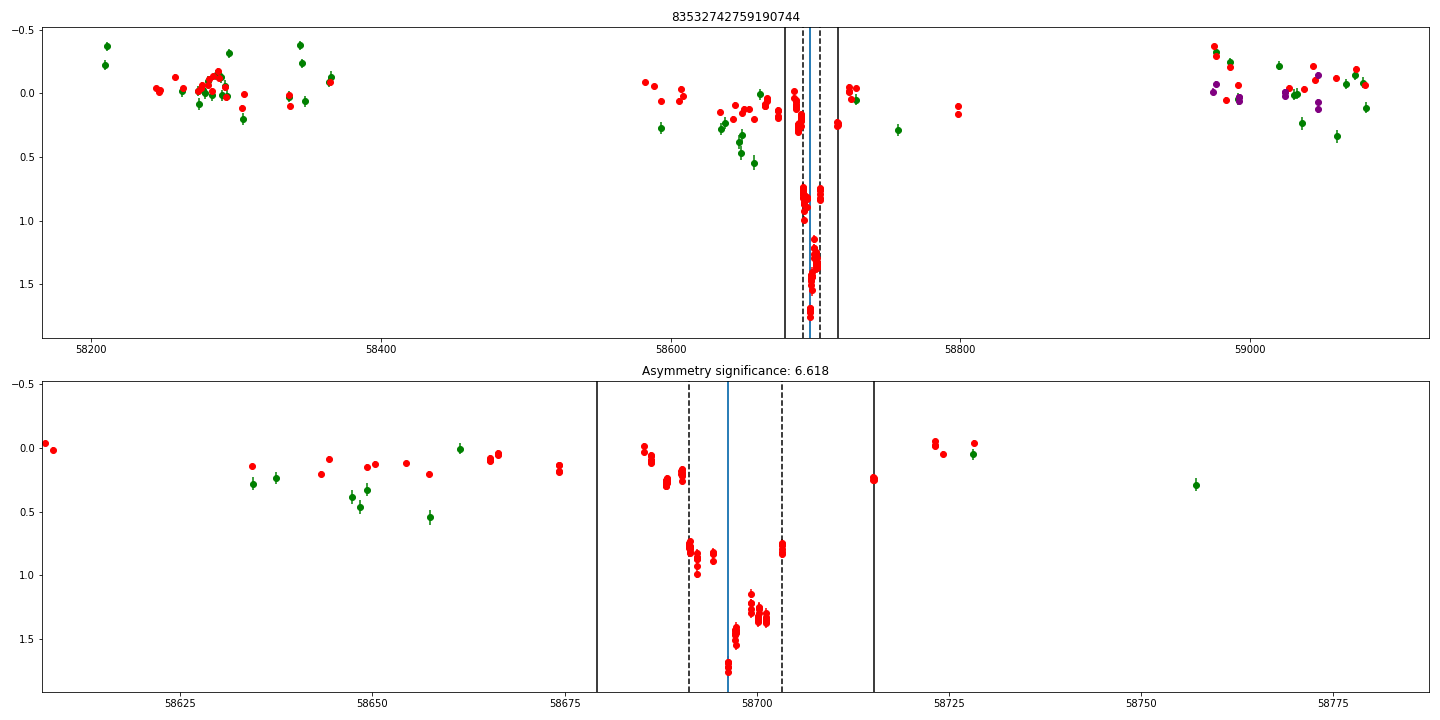

93622748990865634 1


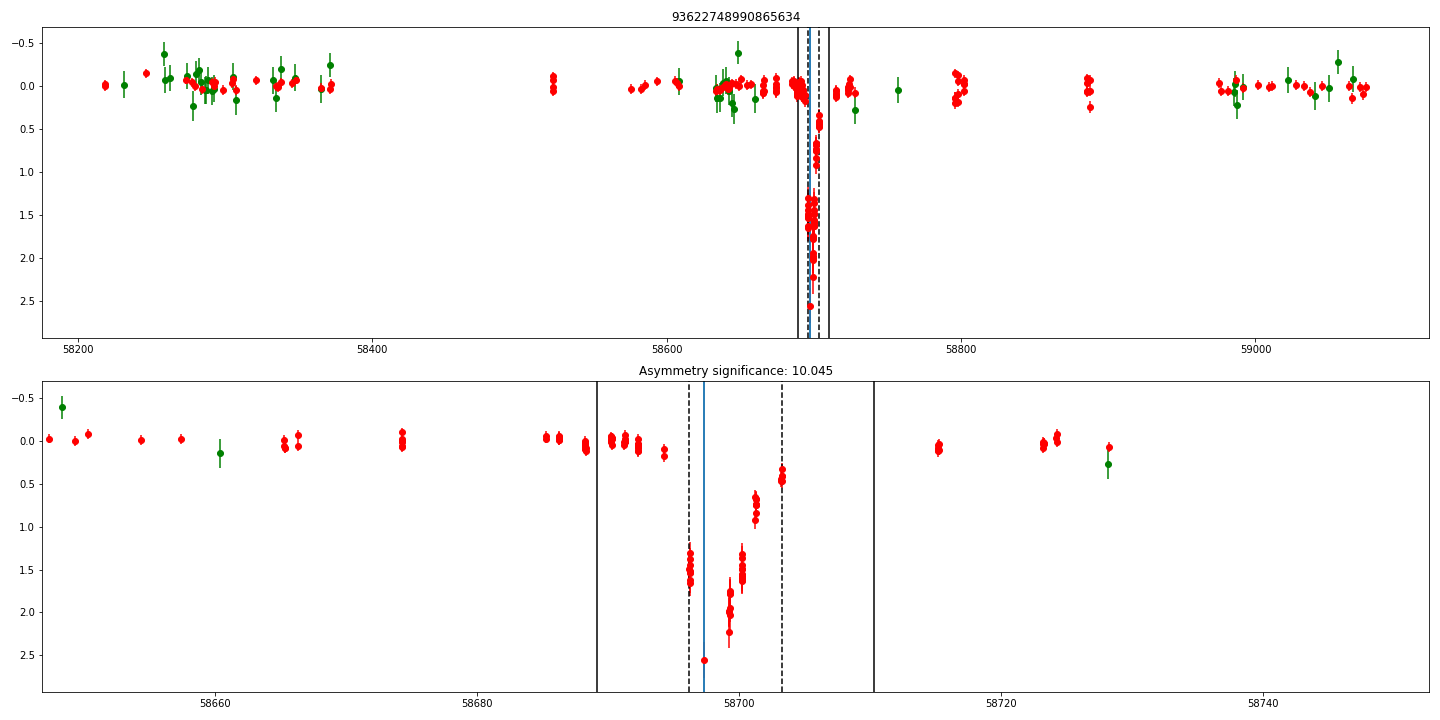

In [26]:
for ps1_id, row in dfzoo.loc[wgold,'ps1_id'].value_counts().iteritems():
        print(ps1_id, row)
        display(Image(f'{image_dir}/{ps1_id}.png'))

### Lithium (or Palladium) sample: out-of-window variability that looks like dips

In [27]:
wlithium = ((dfzoo['flat_outside_window'] == 'No, but the other excursions look like dips') & 
            (dfzoo['dip_both_bands'] == 'Yes') & (dfzoo['asymmetric'] == 'Yes'))

In [28]:
np.sum(wlithium)

28

152933041511544943 2


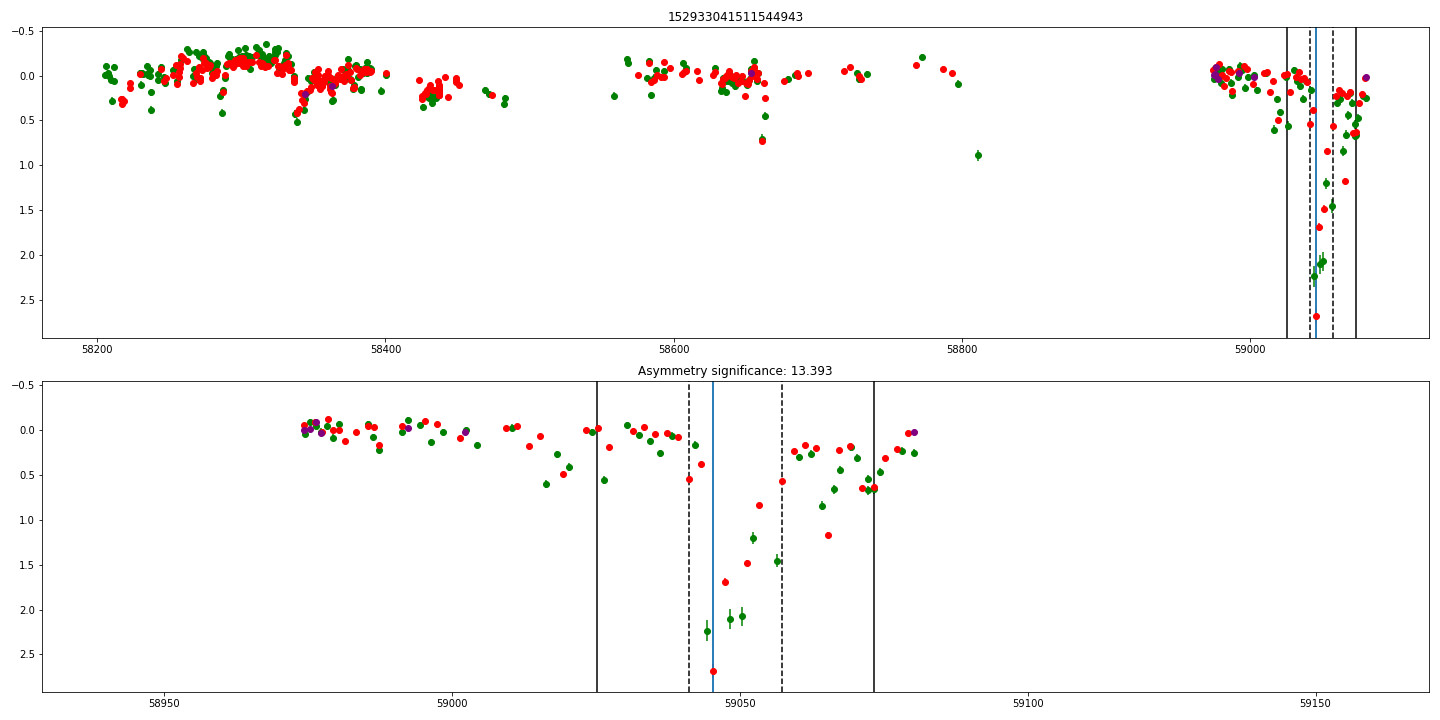

180520455905160075 2


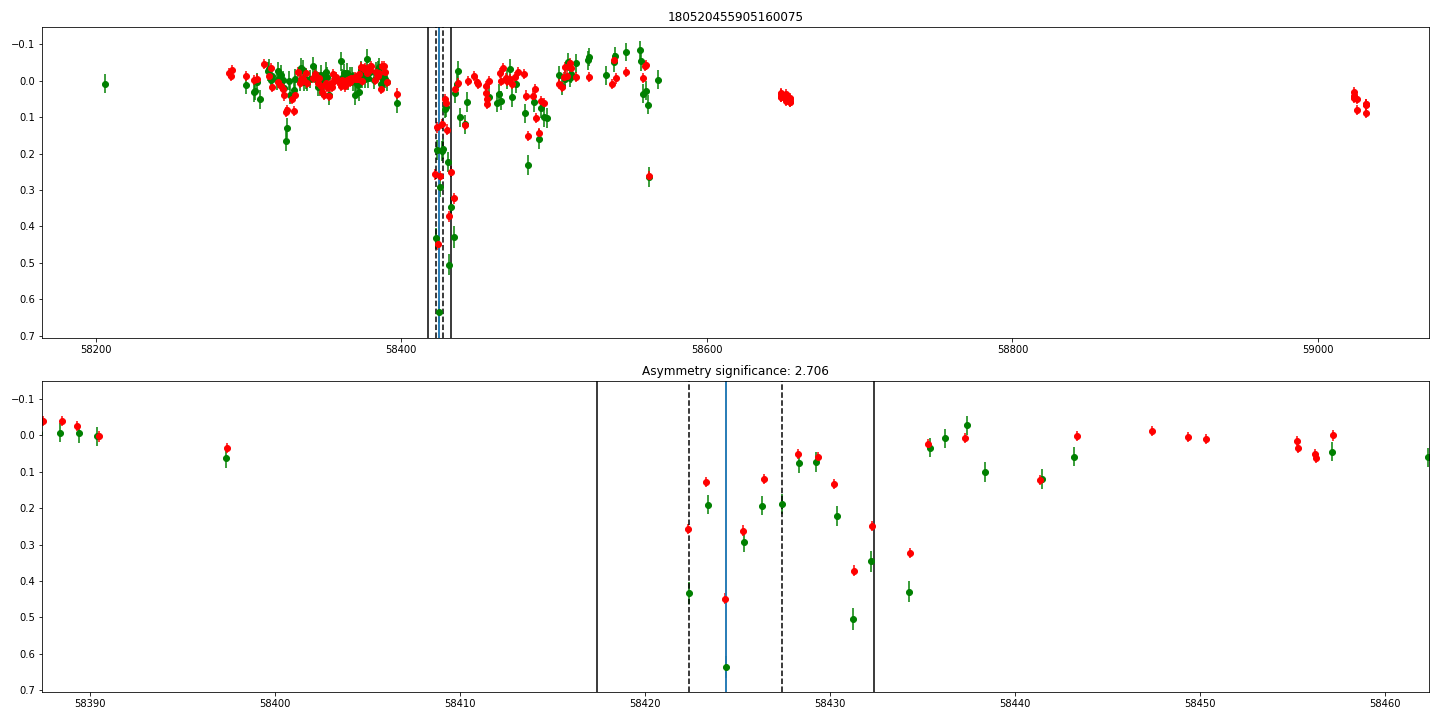

121462843583755431 2


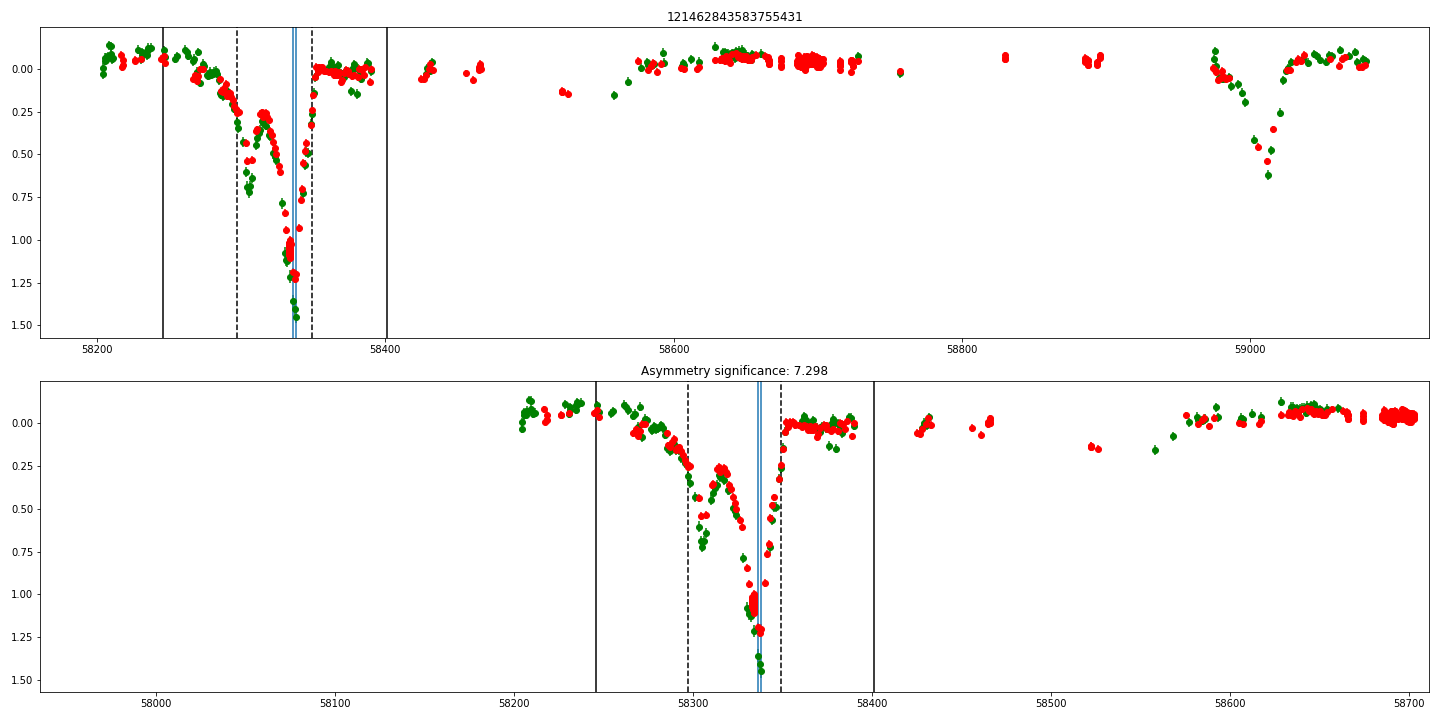

132082932684522435 2


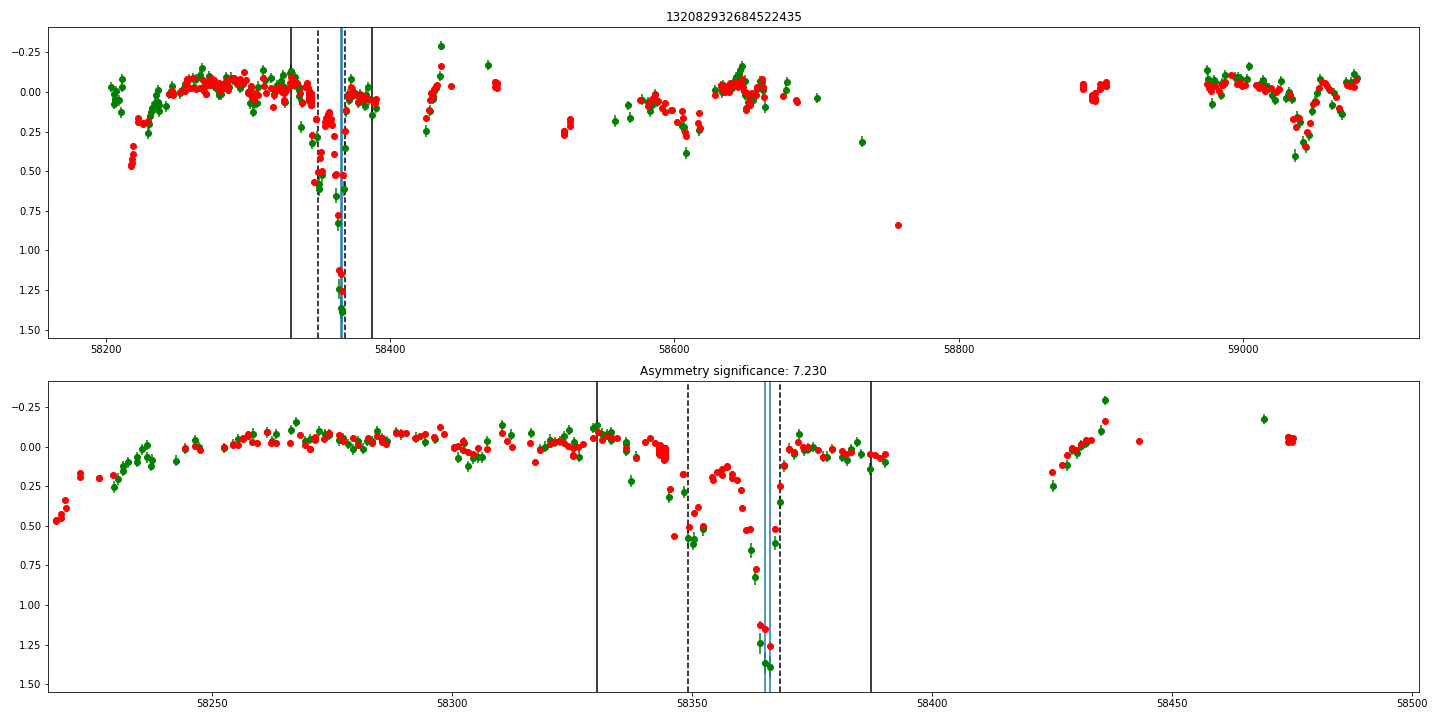

143082996212776354 1


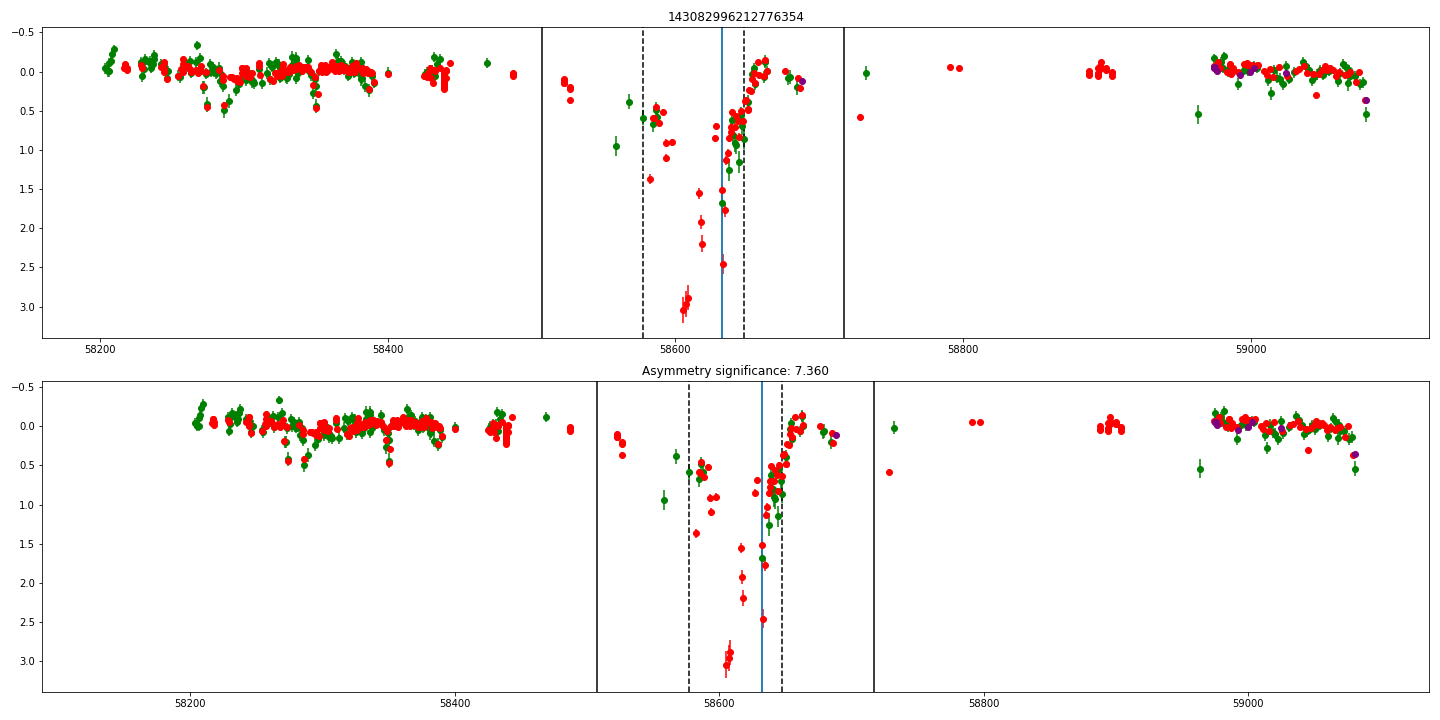

161532987617399987 1


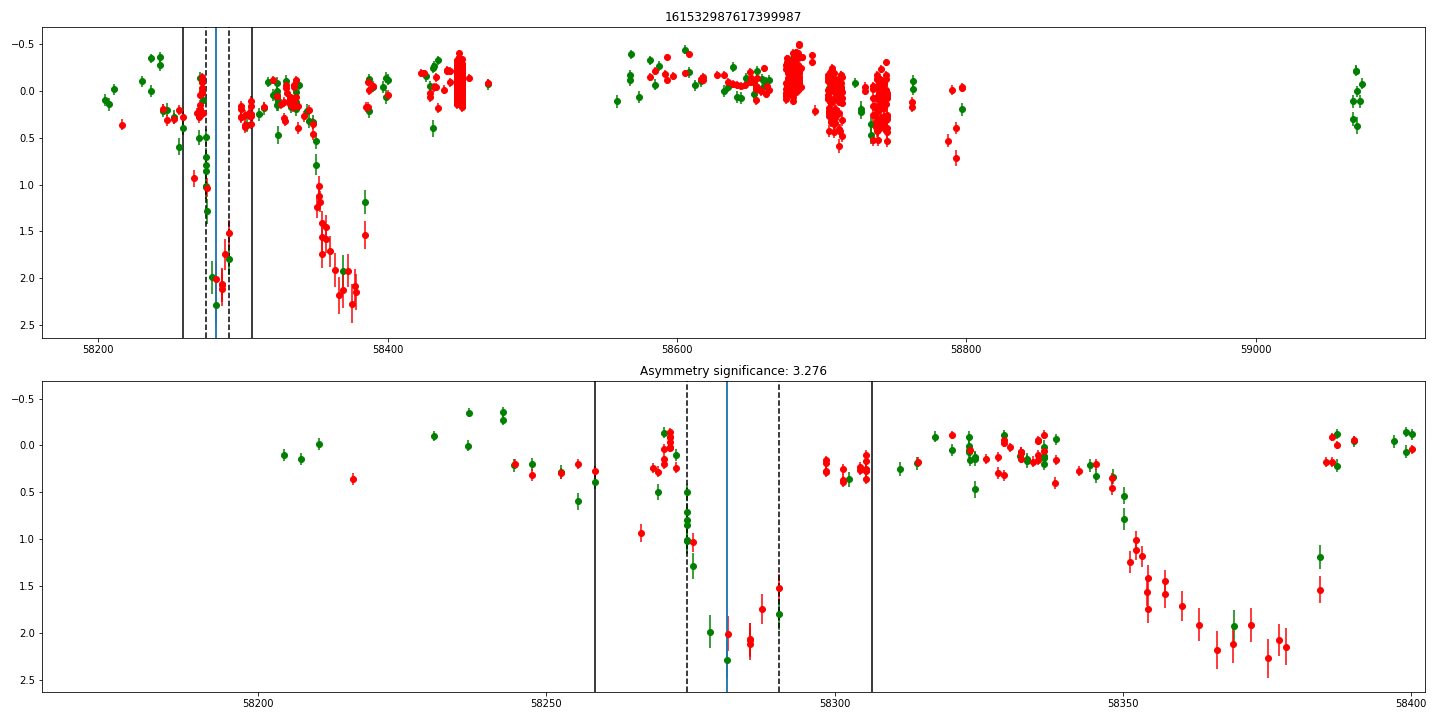

172293364377359859 1


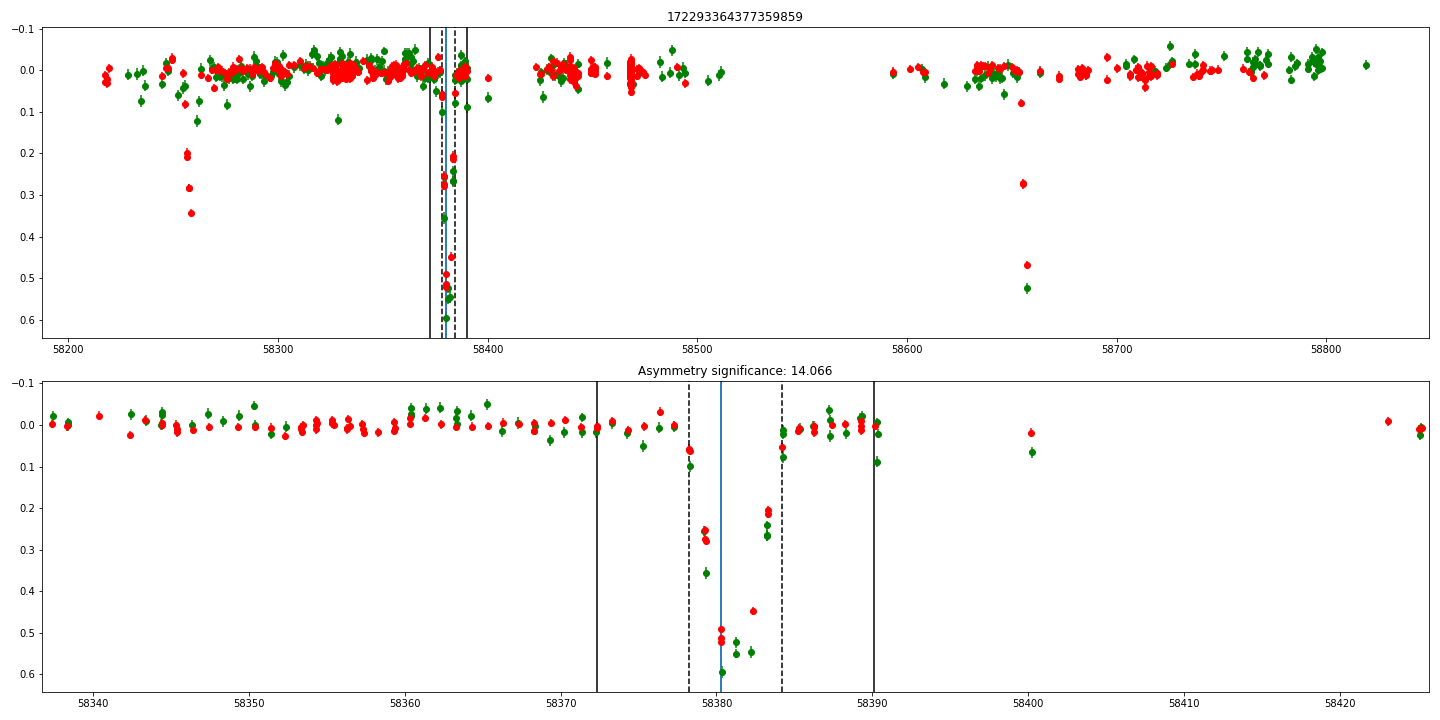

148660734960937072 1


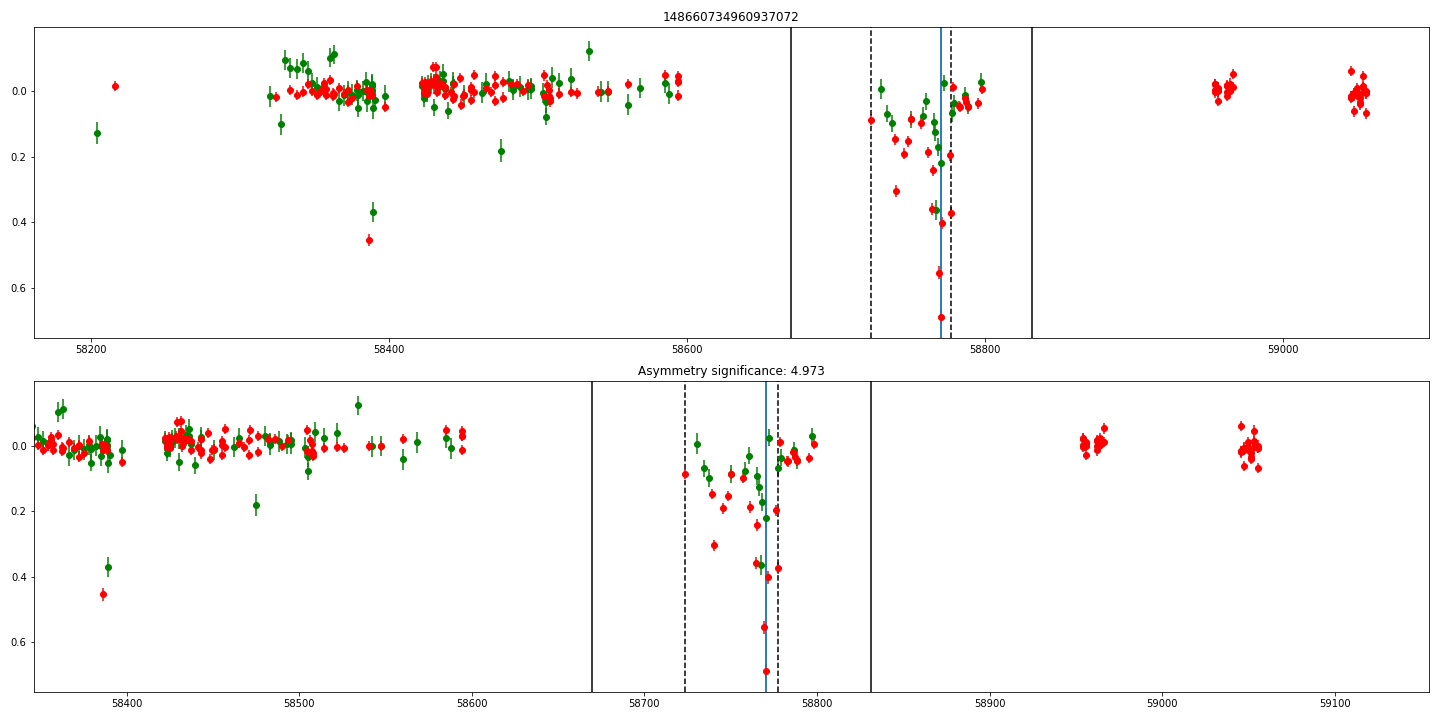

194050053688141851 1


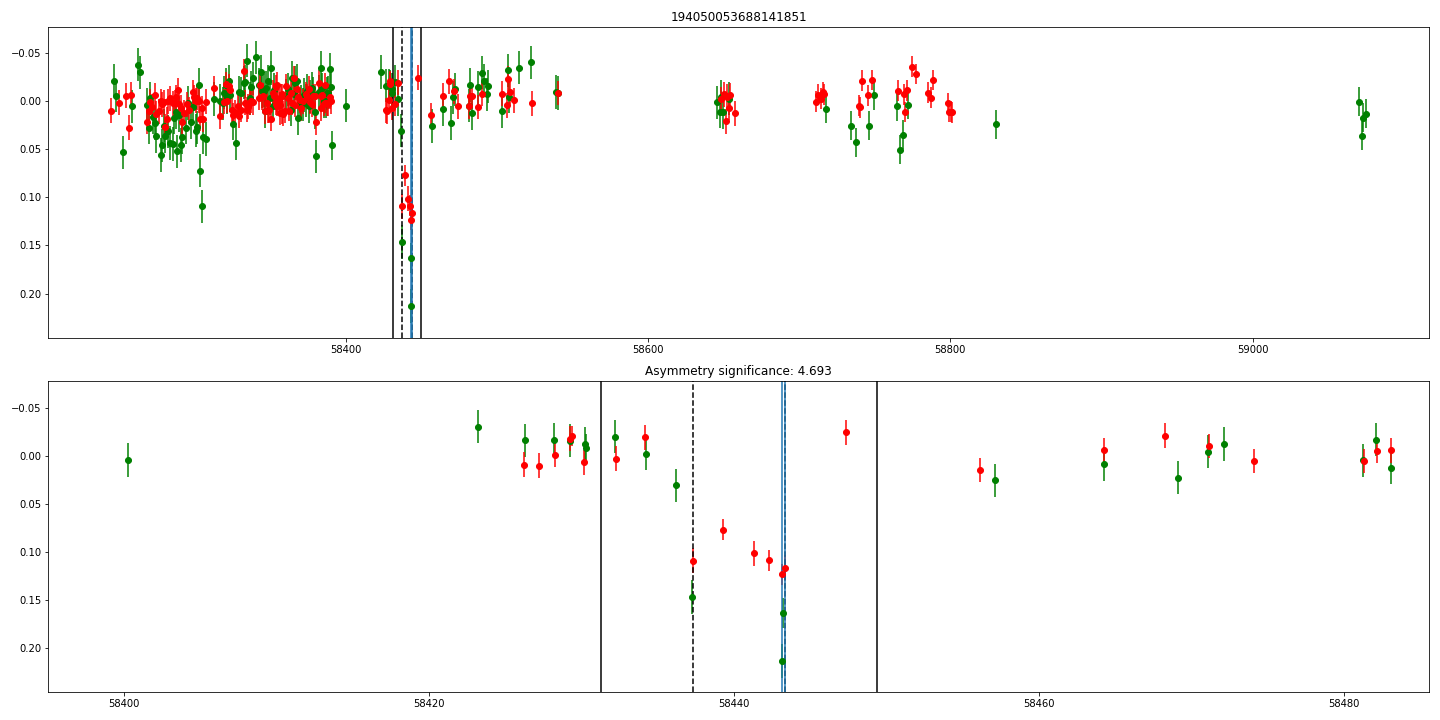

190490161426196096 1


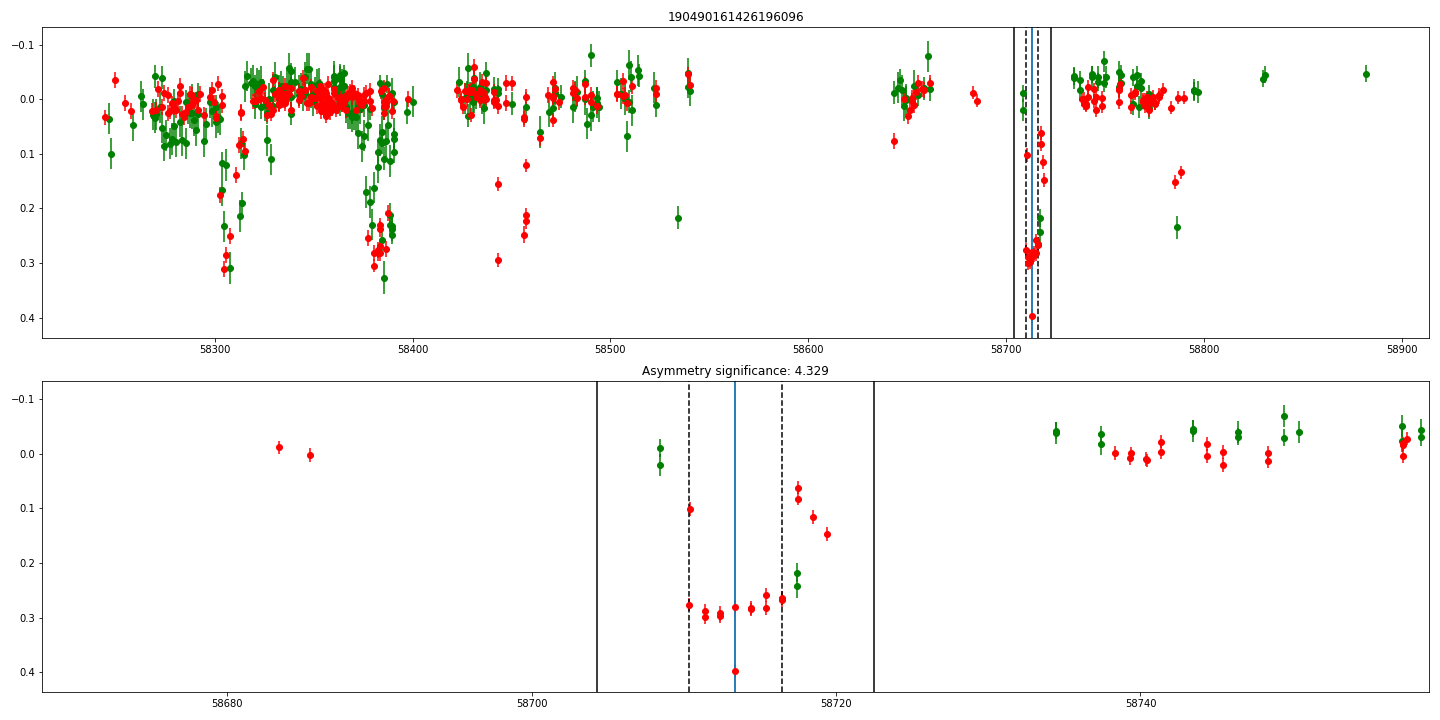

164683281281642831 1


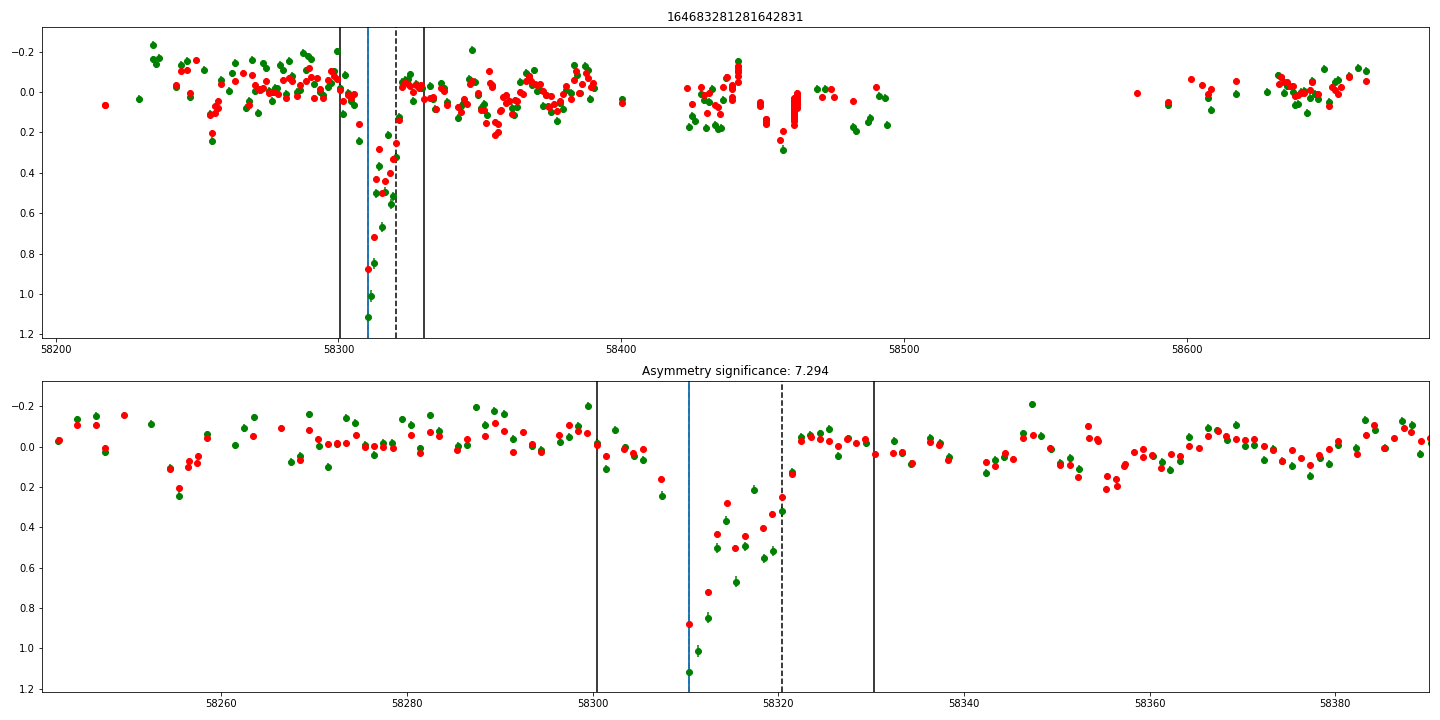

179913489887246089 1


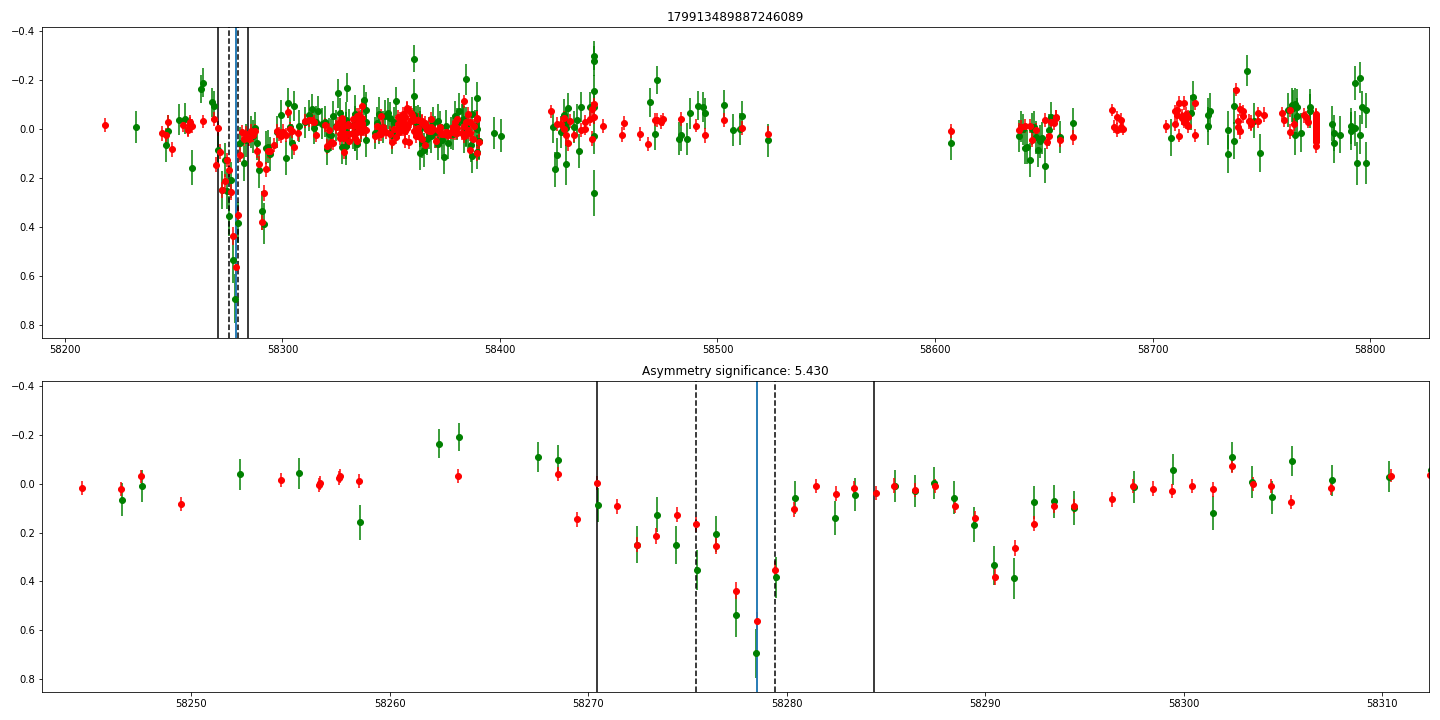

144353021882920367 1


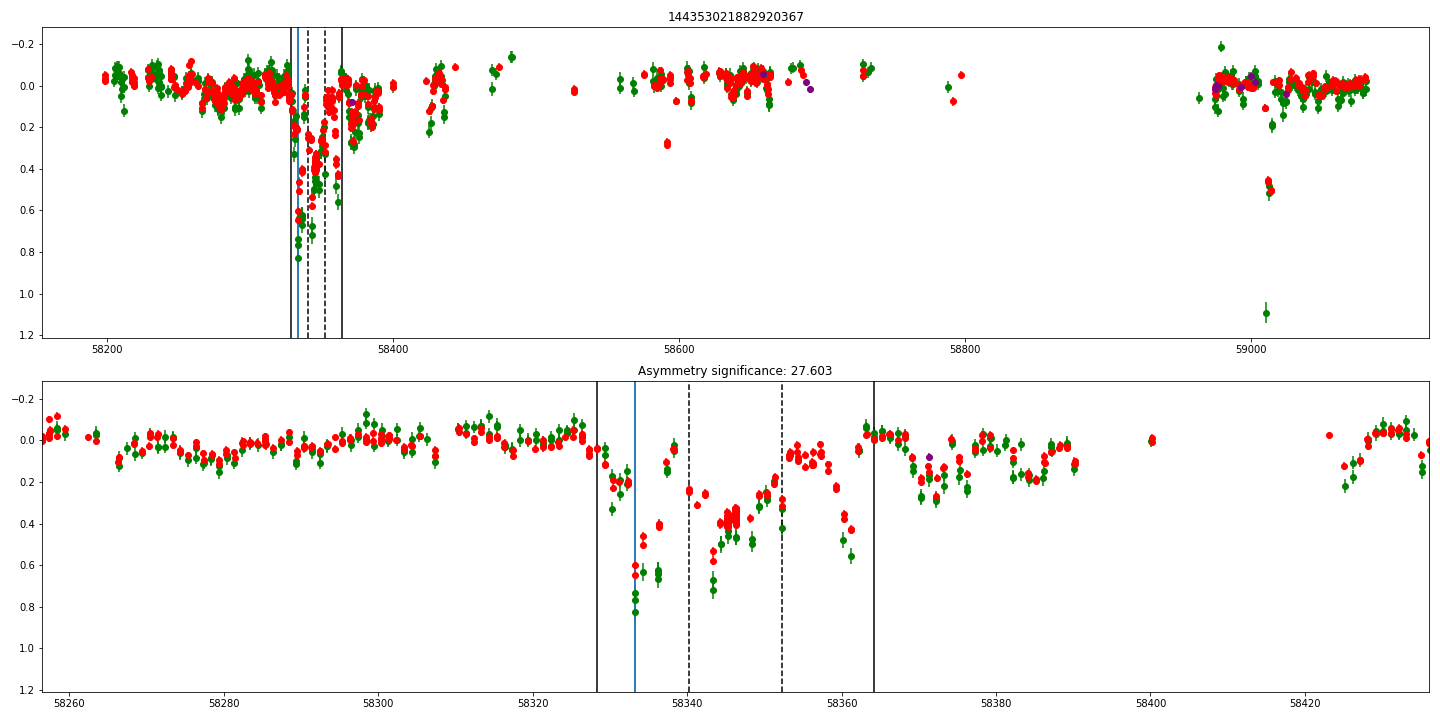

181333458177771942 1


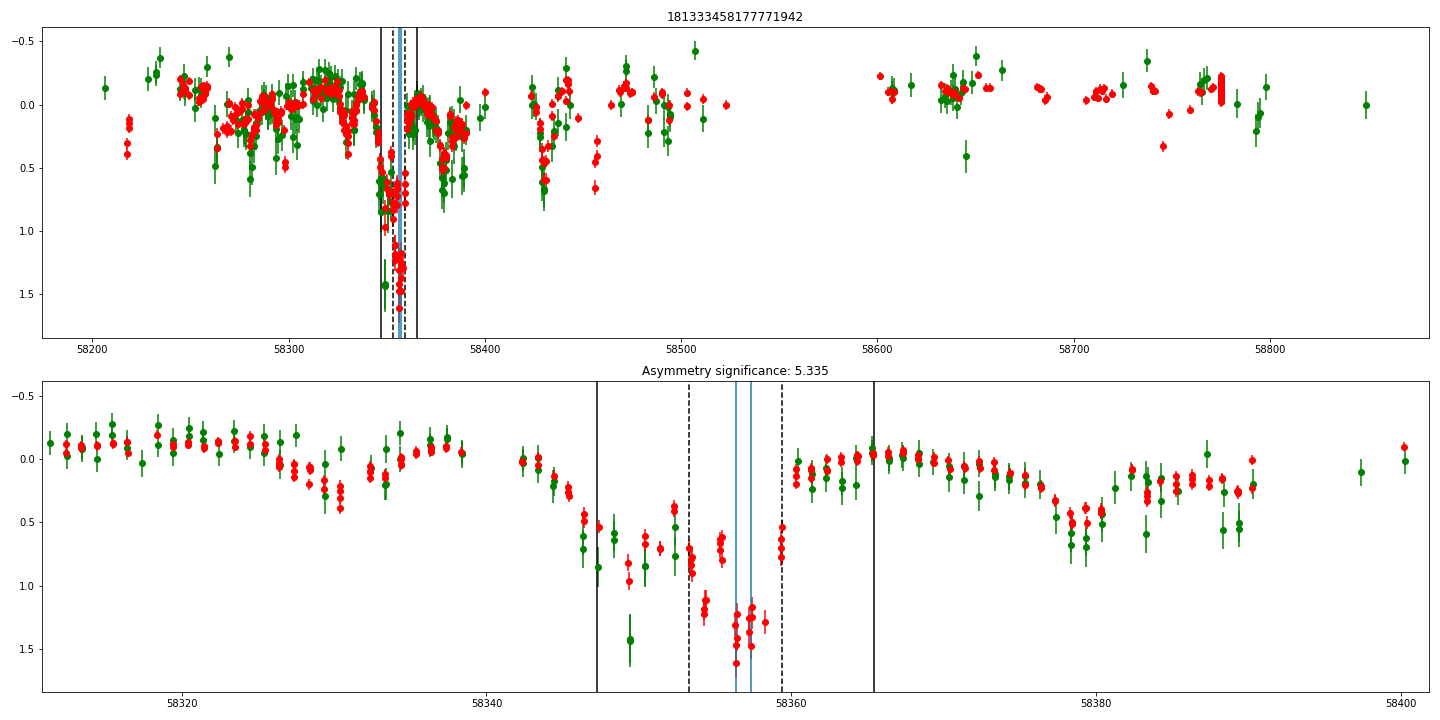

161613074955246719 1


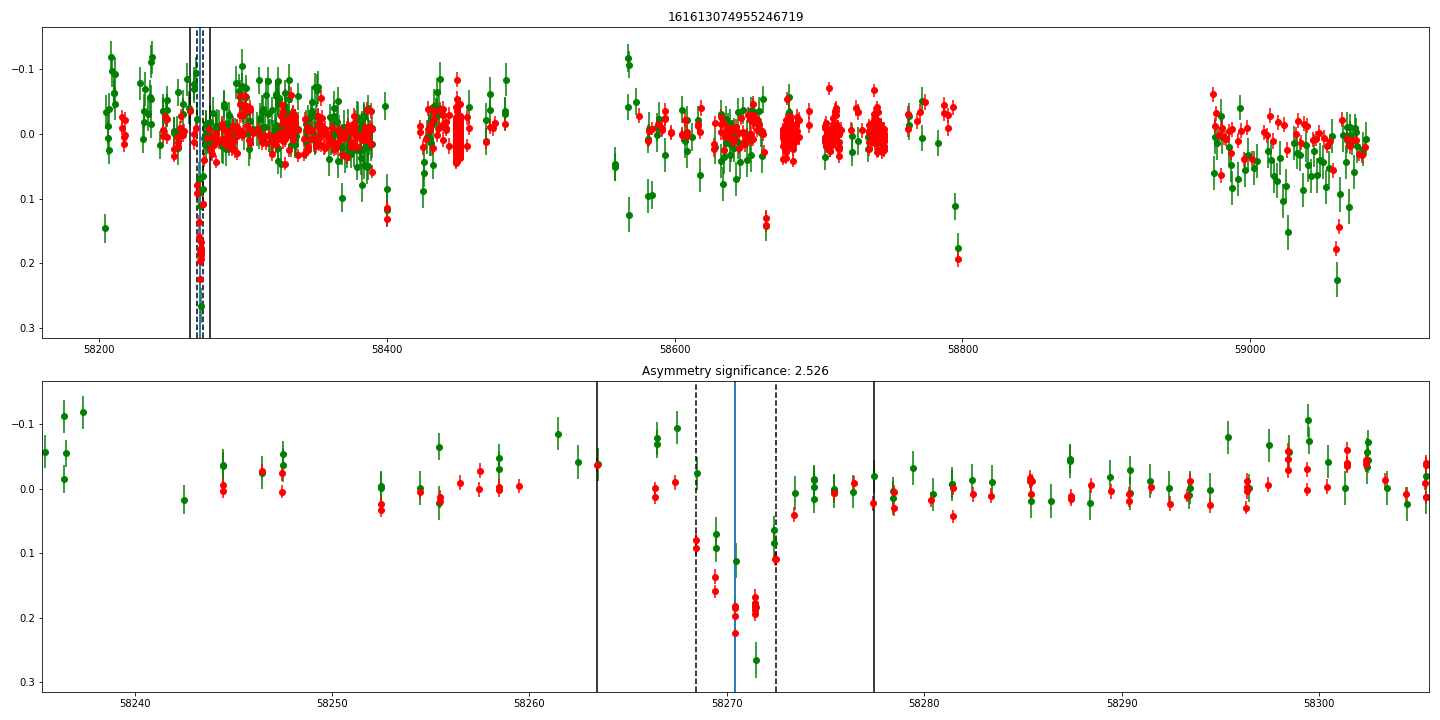

157243045623811979 1


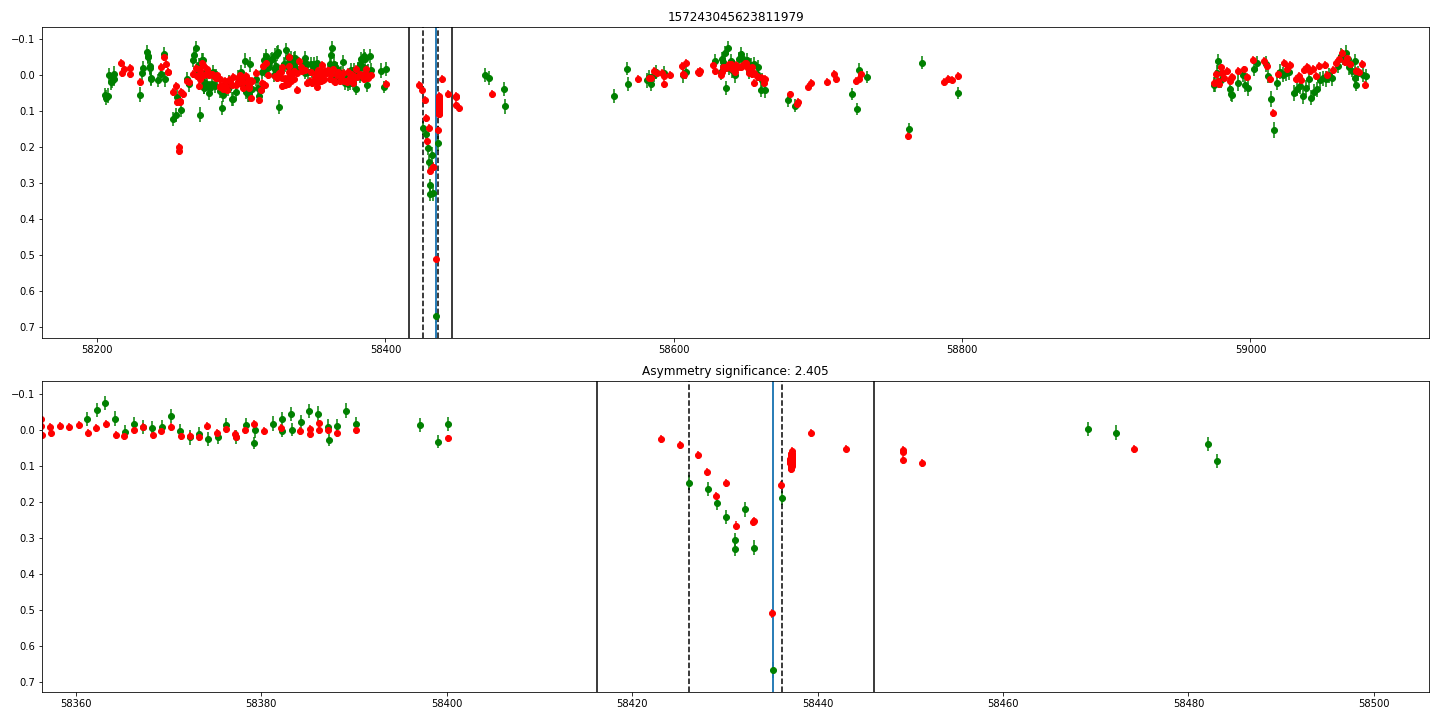

107652811552374789 1


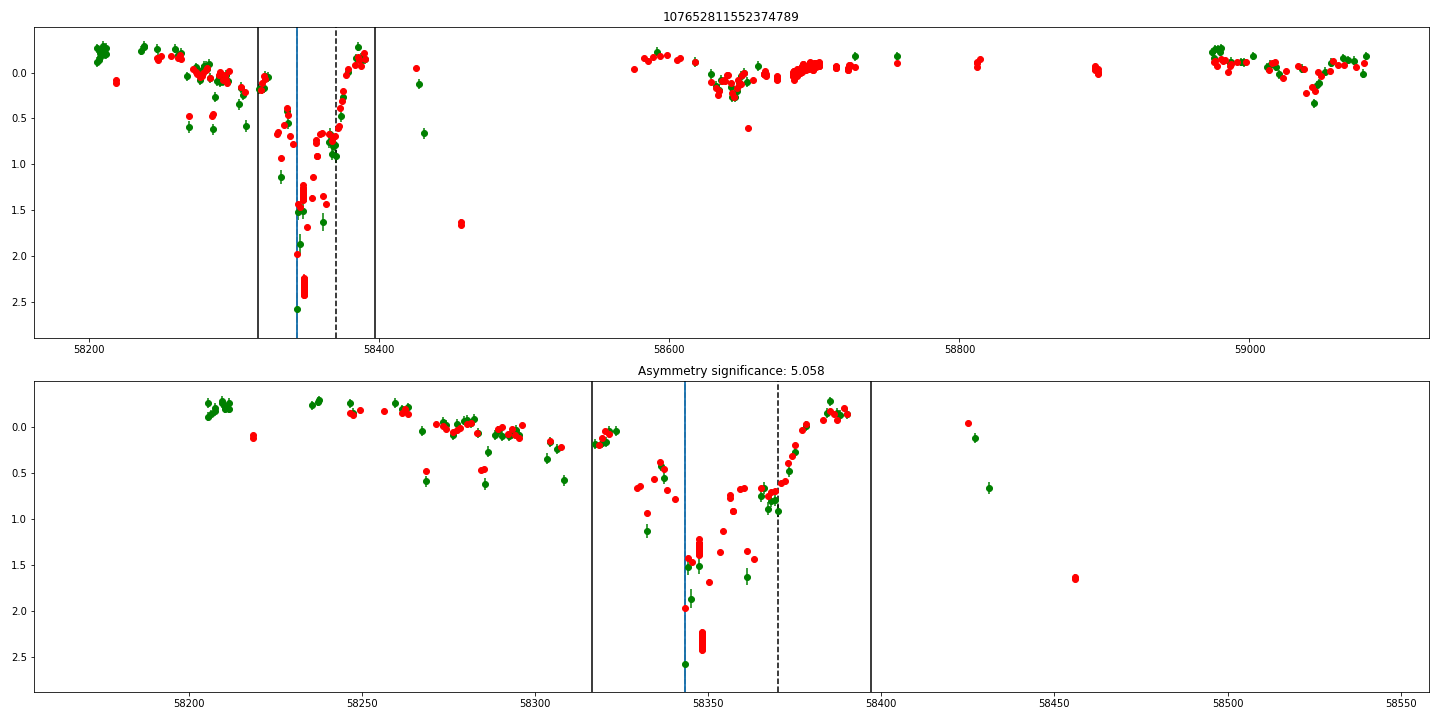

148750732724420133 1


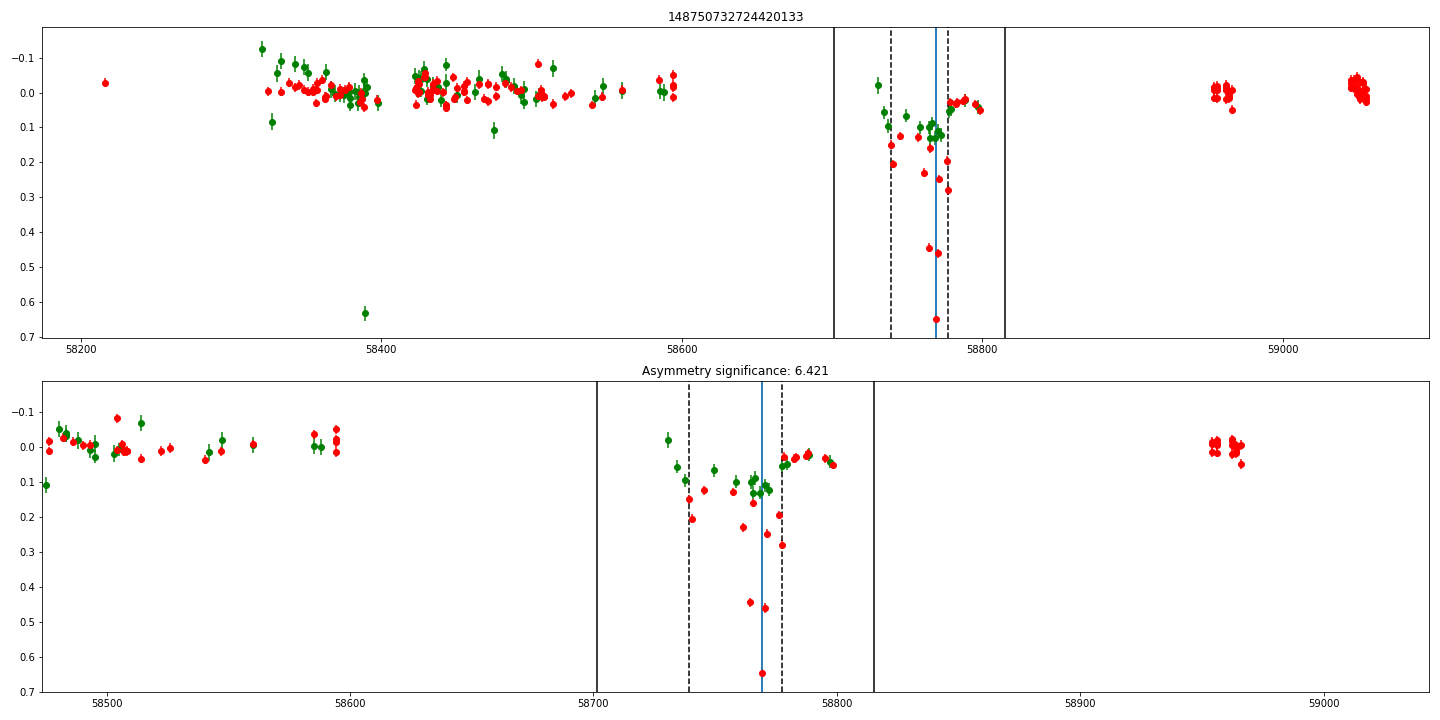

122982836393159285 1


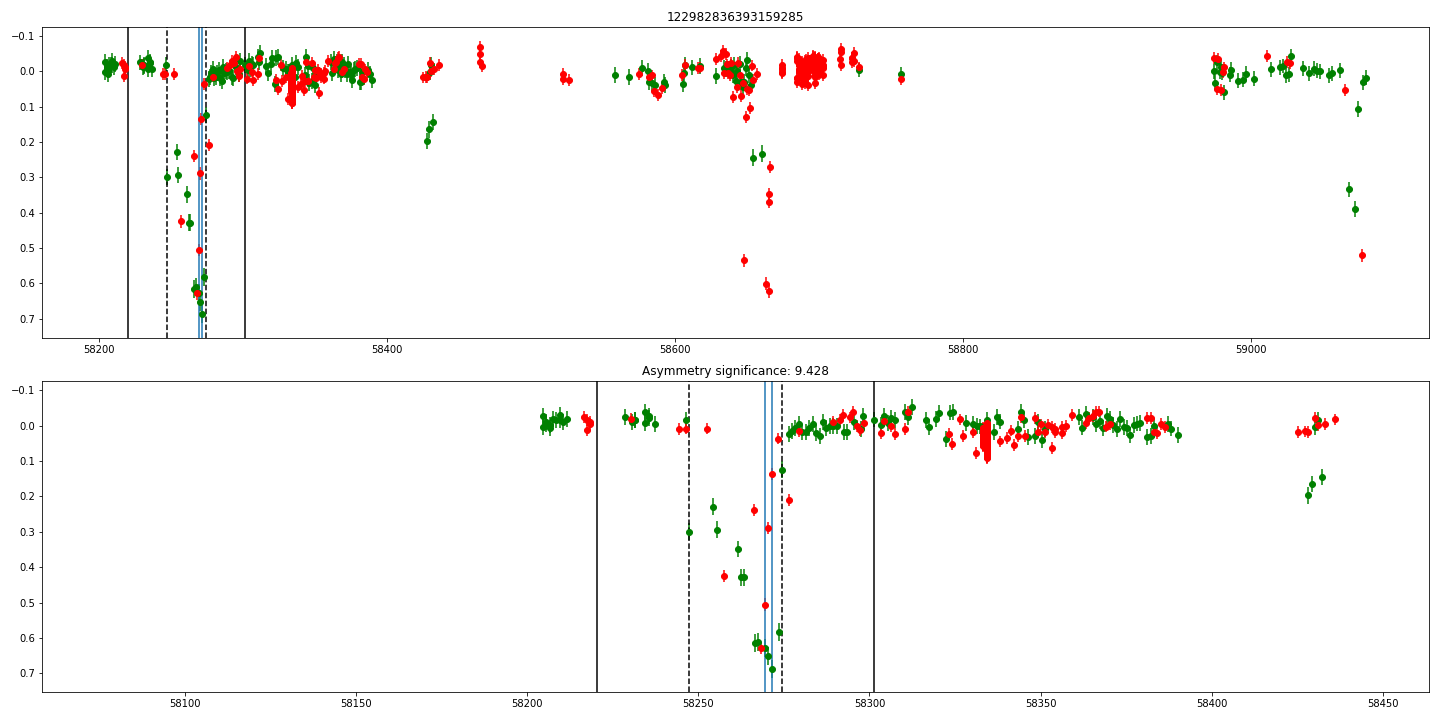

131842928239206558 1


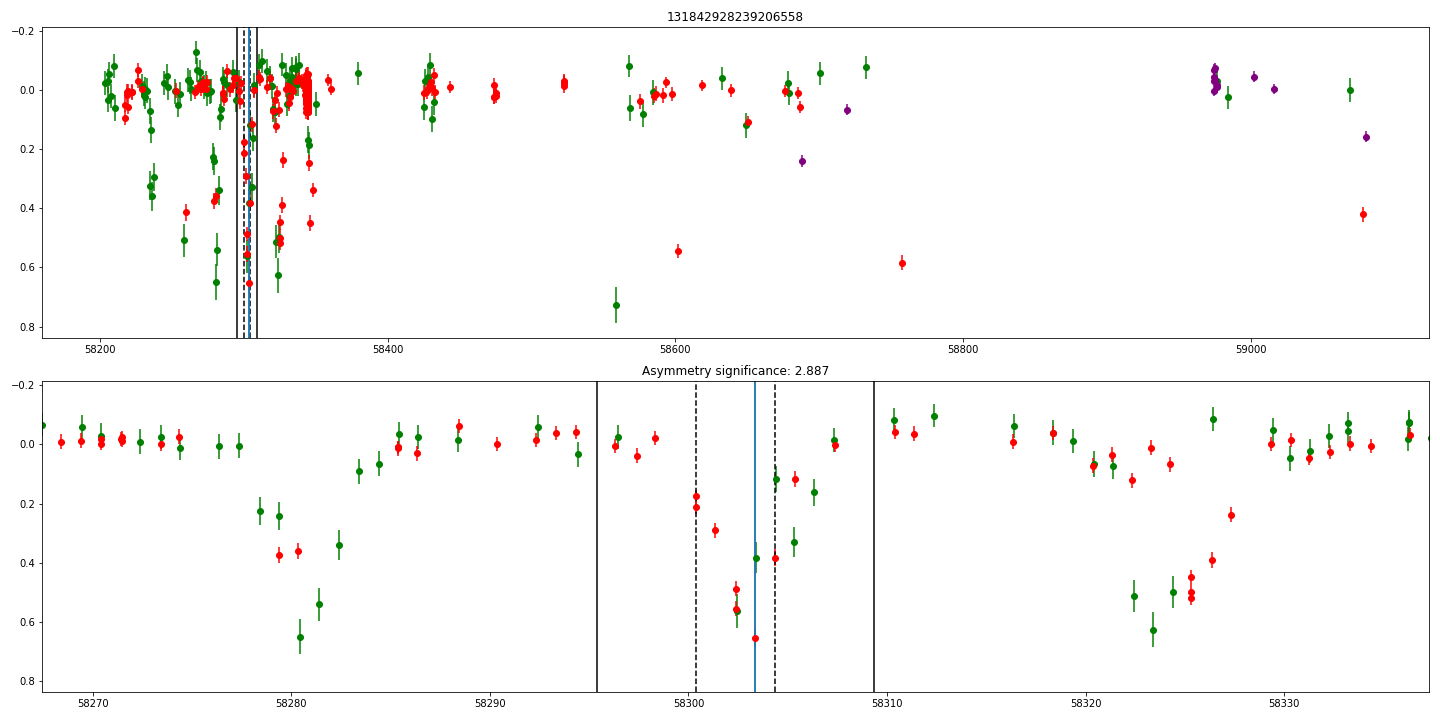

152073046253096391 1


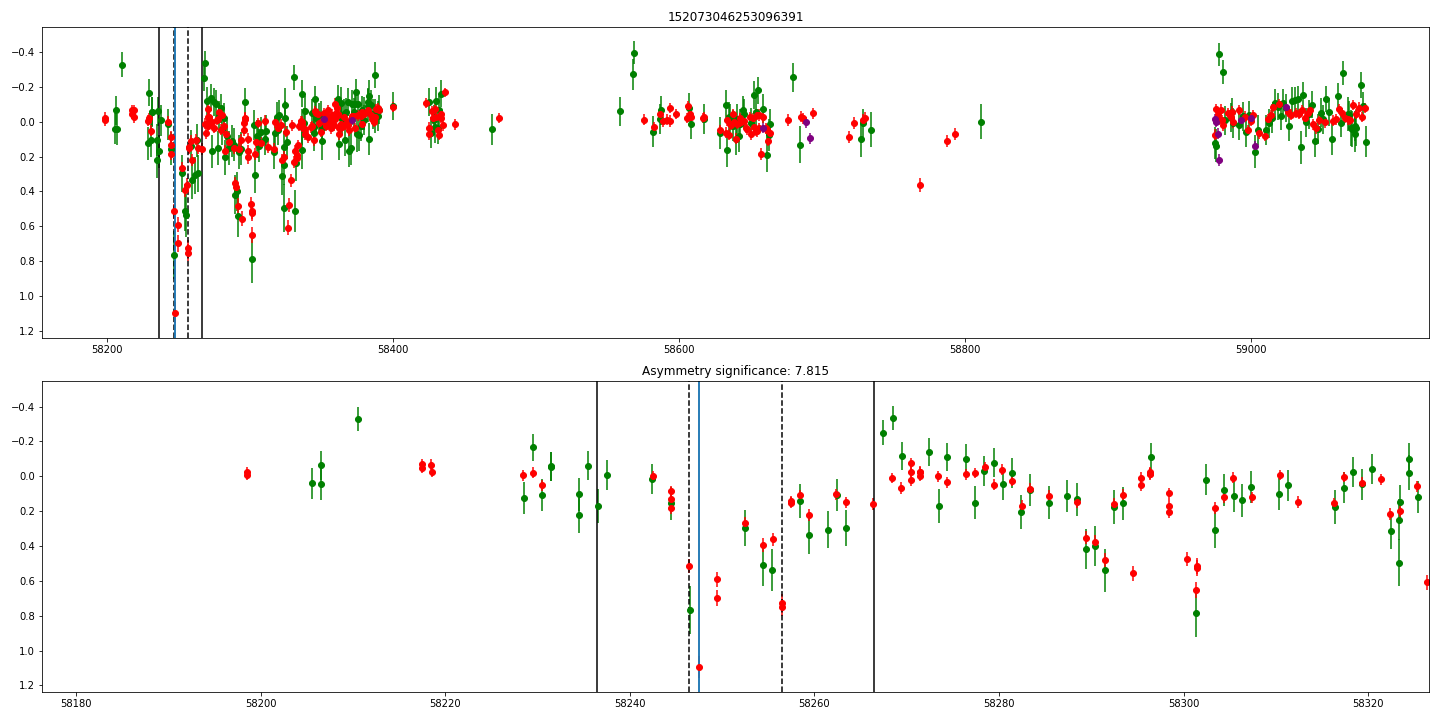

150743022900363199 1


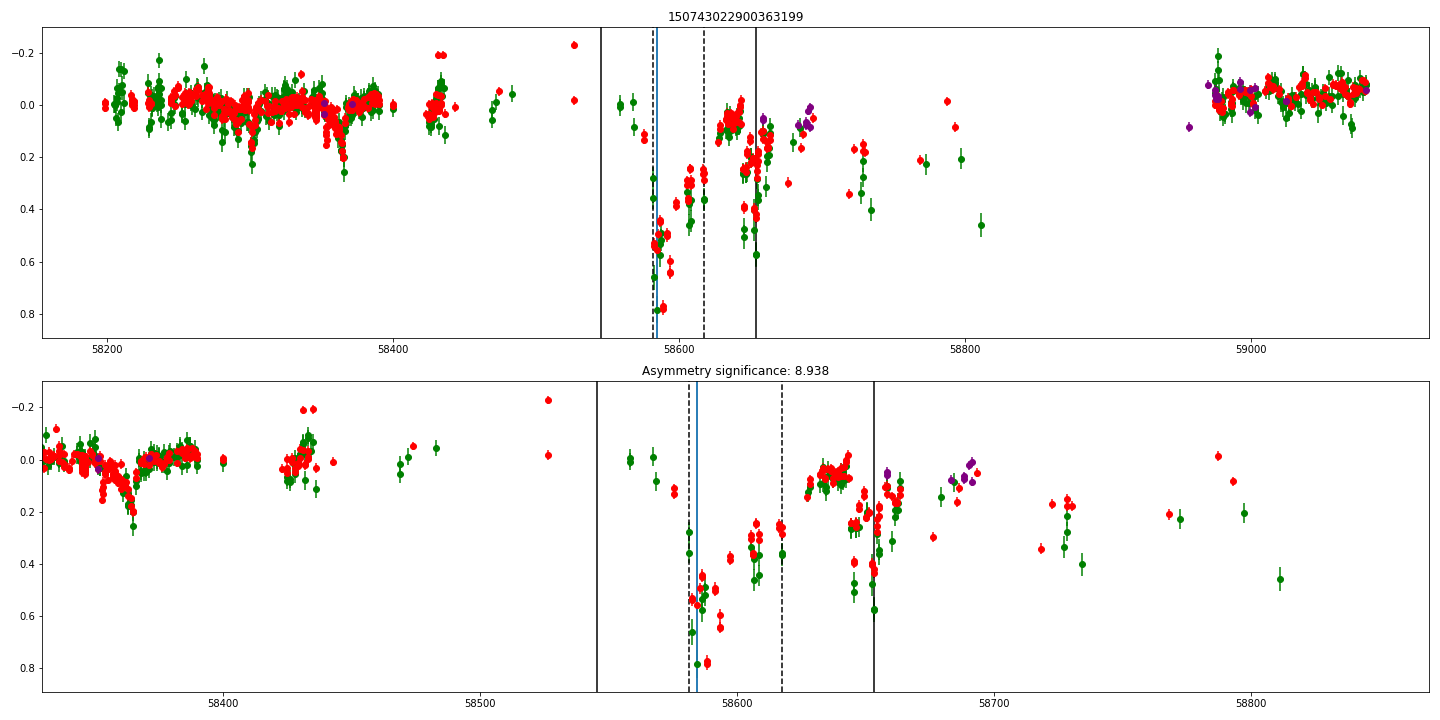

179190031906071693 1


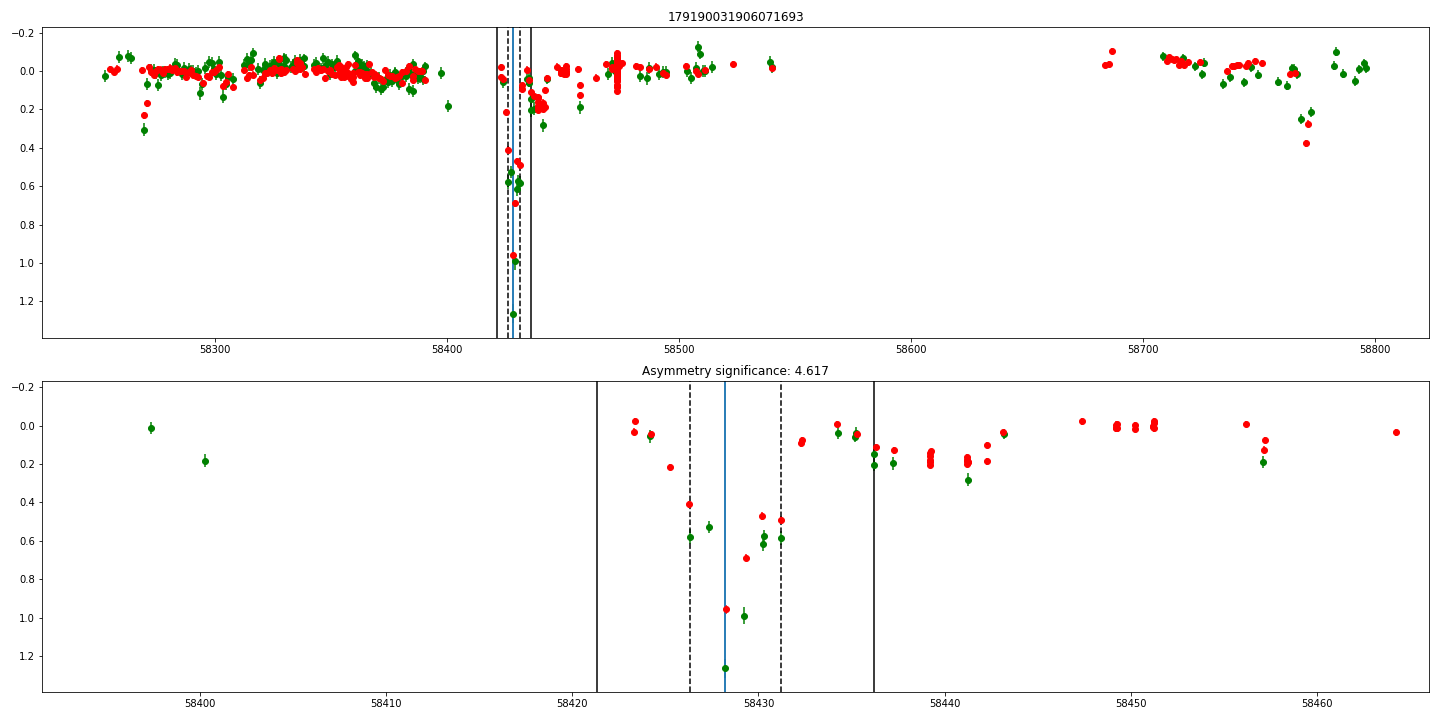

166673111353328416 1


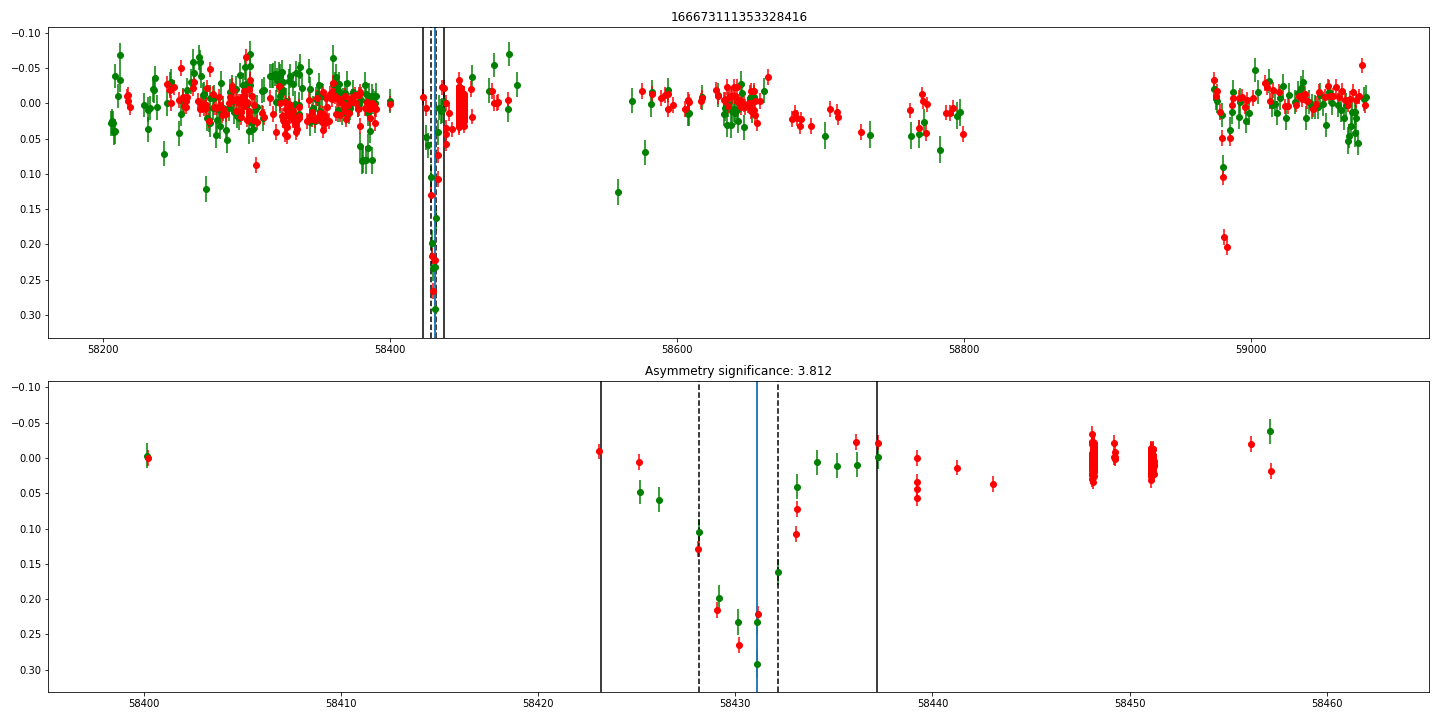

In [29]:
for ps1_id, row in dfzoo.loc[wlithium,'ps1_id'].value_counts().iteritems():
        print(ps1_id, row)
        display(Image(f'{image_dir}/{ps1_id}.png'))

In [30]:
1/0

ZeroDivisionError: division by zero

### dump out results

In [49]:
dfzoo['dip_label'] = 'None'
dfzoo.loc[wplatinum,'dip_label'] = 'Platinum'
dfzoo.loc[wgold,'dip_label'] = 'Gold'
dfzoo.loc[wlithium,'dip_label'] = 'Lithium'

In [50]:
np.sum(wplatinum & wgold)

0

In [51]:
np.sum(wplatinum & wlithium)

0

In [52]:
np.sum(wgold & wlithium)

0

as constructed these classes are disjoint.  we have duplicate rows, though

In [53]:
dfzoo.loc[:,['ps1_id','dip_label']].groupby('ps1_id').agg(lambda x: list(x)[0]).to_csv('ztf_dips_labelled.csv')

In [ ]:
# old v1 code put on ice for now

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(data=dfzoo,y='classification')
#plt.savefig(f'fig/{dataset}/classification_summary.png', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(data=dfzoo.loc[wyes],y='user_name')

In [ ]:
dfzoo.groupby('ps1_id').agg(len)['classification_id'].index[935]

In [ ]:
wmax_id = dfzoo['ps1_id'] == 172521268464107338
dfzoo.loc[wmax_id,['user_name','classification']]

In [ ]:
!ls

In [ ]:
image_dir = '/epyc/users/kyboone/ztf_boyajian/zooniverse/'

In [ ]:
display(Image(f'{image_dir}/172521268464107338.png'))

In [ ]:
wbest = wyes & wwell_sampled 
count_yes = dfzoo[['ps1_id','classification']].loc[wbest].groupby('ps1_id').agg(len)
wtwoyes = count_yes['classification'] > 1
best_ids = count_yes.loc[wtwoyes].index.values


In [ ]:
len(best_ids)

In [ ]:
print(best_ids)

In [ ]:
!mkdir -p gold_sample_figures

In [ ]:
!pwd

In [ ]:
for idi in best_ids:
    display(Image(f'{image_dir}/{idi}.png'))
    shutil.copyfile(f'{image_dir}/{idi}.png', f'gold_sample_figures/{idi}.png')

### Silver sample: at least one yes; number of yeses + maybes >= 2, no sampling check

In [ ]:
# at least one yes
count_yes = dfzoo[['ps1_id','classification']].loc[wyes].groupby('ps1_id').agg(len)
count_yes = count_yes.loc[count_yes['classification'] >= 1]

# any number of maybes
count_maybe = dfzoo[['ps1_id','classification']].loc[wmaybe].groupby('ps1_id').agg(len)

count_yes_and_maybe = count_yes.join(count_maybe,lsuffix='_yes',rsuffix='_maybe',how='outer')

In [ ]:
count_yes_and_maybe.sum(axis=1) 

In [ ]:
wokay = (count_yes_and_maybe.sum(axis=1) >= 2)
okay_ids = count_yes_and_maybe[wokay].index.values

In [ ]:
#remove the duplicated best ids
okay_ids = np.setdiff1d(okay_ids,best_ids)

In [ ]:
len(okay_ids)

In [ ]:
print(okay_ids)

In [ ]:
!mkdir -p silver_sample_figures

In [ ]:
for idi in okay_ids:
    display(Image(f'{image_dir}/{idi}.png'))
    shutil.copyfile(f'{image_dir}/{idi}.png', f'silver_sample_figures/{idi}.png')